# **NBA Career Prediction**
**Predict 5-Year Career Longevity for NBA Rookies**

## WEEK 3 - Feature Selection

In this project, we are trying to classify a rookie player will last at least five years in the NBA or not. This notebook will explore and visualise data and prepare datasets for modelling. The labels are included in the train data, and the goal is to train a model to learn to predict the labels from the features.

Classification: The label is a binary variable, 0 (if career years played < 5), 1 (if career years played >= 5)

The objective of this notebook is to create and select new features. More Data is cleaned, and many features are made this week. We will reduce the number of features using several methods. These include removing features with greater than a threshold percentage of missing values, removing collinear features, and keeping only the most relevant features using feature importances from a model. Then we will test the performance of the features using a reasonably basic gradient boosting machine model.

**The steps are:**
1. Read Data
    * Import Libraries
    * Load data
2. Fill values and create new boolean column 
3. Add features
4. Feature selection
5. Visualiztion

## 1. Read data

##### **[1.1]** Import all modules needed

In [5]:
# Essentials for for data manipulation
import pandas as pd
import numpy as np

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.preprocessing import StandardScaler
from joblib import dump
from sklearn.model_selection import train_test_split
import sklearn.cluster as cluster
from sklearn.metrics import silhouette_score
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import gc
import matplotlib.pyplot as plt
from featuretools import selection



# Other
import warnings
warnings.filterwarnings(action="ignore")
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', None)
#pd.options.display.max_seq_items = 8000
#pd.options.display.max_rows = 200

Please download train.csv and test.csv into data/raw folder then read data in notebook.

##### **[1.2]** Get datasets

In [6]:
# Download train.csv and test.csv into data/raw folder then read data in notebook
df_train = pd.read_csv("../data/raw/train.csv", index_col=0)
print('Training data shape: ', df_train.shape)

df_test = pd.read_csv("../data/raw/test.csv", index_col=0)
print('Testing data shape: ', df_test.shape)

Training data shape:  (8000, 20)
Testing data shape:  (3799, 19)


##### **[1.3]** Prepare dataset for following steps

Combine train and test X in order to apply the feature transformation pipeline to the entire dataset.

In [7]:
# Split X and y, X is all features, y is our target
X_train_raw = df_train.drop(['TARGET_5Yrs'], axis=1)
y_train_raw = df_train['TARGET_5Yrs']
X_test_raw = df_test

# Make a copy of raw dataset, make sure we can check our raw data when we anaysis
X_train = X_train_raw.copy()
y_train = y_train_raw.copy()
X_test  = X_test_raw.copy()

# Combine train and test X
all_X = pd.concat([X_train, X_test]).reset_index(drop=False).set_index('Id')
all_X.head()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
Id,,,,,,,,,,,,,,,,,,,
10556,80,24.3,7.8,3.0,6.4,45.7,0.1,0.3,22.6,2.0,2.9,72.1,2.2,2.0,3.8,3.2,1.1,0.2,1.6
5342,75,21.8,10.5,4.2,7.9,55.1,-0.3,-1.0,34.9,2.4,3.6,67.8,3.6,3.7,6.6,0.7,0.5,0.6,1.4
5716,85,19.1,4.5,1.9,4.5,42.8,0.4,1.2,34.3,0.4,0.6,75.7,0.6,1.8,2.4,0.8,0.4,0.2,0.6
13790,63,19.1,8.2,3.5,6.7,52.5,0.3,0.8,23.7,0.9,1.5,66.9,0.8,2.0,3.0,1.8,0.4,0.1,1.9
5470,63,17.8,3.7,1.7,3.4,50.8,0.5,1.4,13.7,0.2,0.5,54.0,2.4,2.7,4.9,0.4,0.4,0.6,0.7


## 2. Fill values and create new boolean column

Fill in the anomalous values with not a number (np.nan) and then create a new boolean column indicating whether or not the value was anomalous.

##### **[2.1]** Recalculate variables

From last week, we find FT% calculated based on FTM and FTA is having a maximum value of 200% which is impossible, which means there are hidden problems in FTM & FTA. Also, NBA official highest 3P% is around 45%, which is much lower than the maximum 82.1% here, recalculate 3P%.

Recalculate four variables FT%, 3P%, FG%, REB contained in the raw test dataset, which can be calculated based on the other variables in the same dataset.

In [8]:
# recalculate FT%, since the FT% > 100 is not possible
all_X['FT%'] = all_X['FTM'] / all_X['FTA'] * 100

# recalculate 3P%, since NBA official highest 3P% is around 45%
all_X['3P%'] = all_X['3P Made'] / all_X['3PA'] * 100

# recalculate FG%, since above 2 columns are wrong, check for correctness
all_X['FG%'] = all_X['FGM'] / all_X['FGA'] * 100

# recalculate REB
all_X['REB'] = all_X['OREB'] + all_X['DREB']

# check describe again
all_X.describe()
all_X.info()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
count,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,1.163600e+04,11799.000000,11799.000000,11790.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000
mean,62.802356,18.600347,7.286711,2.816171,6.254191,44.639429,0.261768,0.810238,NaN,1.394881,1.949648,71.351301,1.083694,2.172040,3.255734,1.628367,0.650267,0.249241,1.257810
std,17.128705,8.868520,4.310929,1.691763,3.582845,6.230051,0.383100,1.058358,NaN,0.926116,1.251666,12.141528,0.785685,1.385675,2.056339,1.349378,0.408566,0.767327,0.719774
min,-8.000000,2.900000,0.700000,0.300000,0.800000,25.000000,-1.100000,-3.100000,-inf,0.000000,0.000000,0.000000,0.000000,0.200000,0.200000,0.000000,0.000000,-17.900000,0.100000
25%,51.000000,12.050000,4.100000,1.600000,3.600000,40.322581,0.000000,0.100000,2.857143e+01,0.700000,1.000000,63.888889,0.500000,1.200000,1.700000,0.700000,0.400000,0.100000,0.700000
50%,63.000000,16.900000,6.400000,2.400000,5.500000,44.444444,0.300000,0.800000,3.333333e+01,1.200000,1.700000,70.967742,0.900000,1.900000,2.800000,1.300000,0.600000,0.200000,1.100000
75%,74.000000,23.400000,9.500000,3.700000,8.100000,48.648649,0.500000,1.500000,4.000000e+01,1.900000,2.600000,78.125000,1.500000,2.900000,4.300000,2.200000,0.900000,0.400000,1.600000
max,126.000000,73.800000,34.200000,13.400000,28.900000,81.250000,1.700000,4.700000,inf,8.100000,11.100000,200.000000,6.900000,12.000000,17.300000,12.800000,3.600000,18.900000,5.300000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 11799 entries, 10556 to 8183
Data columns (total 19 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   GP       11799 non-null  int64  
 1   MIN      11799 non-null  float64
 2   PTS      11799 non-null  float64
 3   FGM      11799 non-null  float64
 4   FGA      11799 non-null  float64
 5   FG%      11799 non-null  float64
 6   3P Made  11799 non-null  float64
 7   3PA      11799 non-null  float64
 8   3P%      11636 non-null  float64
 9   FTM      11799 non-null  float64
 10  FTA      11799 non-null  float64
 11  FT%      11790 non-null  float64
 12  OREB     11799 non-null  float64
 13  DREB     11799 non-null  float64
 14  REB      11799 non-null  float64
 15  AST      11799 non-null  float64
 16  STL      11799 non-null  float64
 17  BLK      11799 non-null  float64
 18  TOV      11799 non-null  float64
dtypes: float64(18), int64(1)
memory usage: 1.8 MB


Check columns after recalculating four variables.

In [9]:
# Use if need:
# pd.options.display.max_rows = 8000

# find 3P% = inf - 162 rows
print("Rows of 3P% = inf")
all_X[np.isinf(all_X['3P%'])]
print()

# 3P Made > 3PA, 2221 rows
print("Rows of 3P Made > 3PA")
all_X[all_X['3P Made'] > all_X['3PA']]
print()

# 3P% = nan, 163 rows
print("Rows of 3P% = nan")
all_X[np.isnan(all_X['3P%'])]
print()

# FG% = nan, 0 rows
print("Rows of FG% = nan")
all_X[np.isnan(all_X['FG%'])]
print()

# FT = nan,  9 rows
print("Rows of FT = nan")
all_X[np.isnan(all_X['FT%'])]
print()

# Check info
print("Check info")
all_X.info()
print()

# Check dataframe
print("Check describe")
all_X.describe()

Rows of 3P% = inf


,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
Id,,,,,,,,,,,,,,,,,,,
1757,91,29.1,8.1,3.6,5.9,61.016949,0.1,-0.0,-inf,1.3,1.9,68.421053,2.1,2.8,4.9,2.2,1.4,0.2,1.7
8651,72,14.2,8.2,2.9,6.4,45.312500,-0.1,-0.0,inf,2.4,3.1,77.419355,0.6,1.5,2.1,1.5,0.7,0.2,1.9
10676,41,9.4,3.9,1.5,3.4,44.117647,0.1,-0.0,-inf,0.9,1.6,56.250000,0.5,0.9,1.4,0.8,0.1,0.2,0.5
4799,68,19.4,7.2,3.0,6.8,44.117647,-0.1,0.0,-inf,1.1,1.6,68.750000,1.6,2.3,3.9,0.6,0.8,0.1,1.3
8365,72,20.5,7.3,2.9,6.5,44.615385,-0.1,0.0,-inf,1.6,2.0,80.000000,1.3,2.7,4.0,2.2,0.8,0.4,2.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7359,43,9.9,4.2,1.6,3.4,47.058824,-0.1,0.0,-inf,0.8,1.1,72.727273,0.8,1.5,2.3,0.5,0.3,0.3,1.0
7539,68,13.5,3.7,1.8,3.7,48.648649,0.1,-0.0,-inf,0.1,0.3,33.333333,0.3,1.6,1.9,0.8,0.3,-0.5,0.6
7653,39,15.9,4.8,2.0,4.1,48.780488,-0.1,0.0,-inf,0.6,1.1,54.545455,1.2,2.3,3.5,0.8,0.6,0.3,0.9



Rows of 3P Made > 3PA


,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
Id,,,,,,,,,,,,,,,,,,,
5342,75,21.8,10.5,4.2,7.9,53.164557,-0.3,-1.0,30.000000,2.4,3.6,66.666667,3.6,3.7,7.3,0.7,0.5,0.6,1.4
1961,88,20.0,8.8,3.7,8.7,42.528736,-0.2,-0.5,40.000000,2.0,2.8,71.428571,1.8,2.9,4.7,1.8,0.4,0.3,1.1
2677,70,20.6,7.0,3.2,5.4,59.259259,0.1,-0.1,-100.000000,0.7,1.4,50.000000,2.9,4.6,7.5,0.6,0.4,0.7,1.2
13144,41,9.8,2.3,0.9,2.3,39.130435,-0.4,-0.6,66.666667,0.9,1.3,69.230769,1.5,1.9,3.4,0.2,0.3,0.4,0.4
3062,83,8.5,2.2,0.9,1.8,50.000000,-0.3,-1.0,30.000000,0.5,0.9,55.555556,0.2,0.6,0.8,1.3,0.4,0.2,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8148,64,10.4,3.1,1.3,3.6,36.111111,-0.4,-0.9,44.444444,0.5,0.6,83.333333,0.5,0.5,1.0,1.4,0.5,-0.0,0.9
8165,59,8.6,2.8,1.3,2.3,56.521739,-0.1,-0.6,16.666667,0.3,0.6,50.000000,1.0,2.6,3.6,0.0,0.1,0.6,0.2
8166,60,11.7,7.2,3.2,5.7,56.140351,-0.1,-0.4,25.000000,0.8,1.2,66.666667,0.7,1.2,1.9,0.5,0.5,0.2,1.0



Rows of 3P% = nan


,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
Id,,,,,,,,,,,,,,,,,,,
3556,34,10.5,3.3,1.2,2.7,44.444444,0.0,0.0,NaN,1.2,1.7,70.588235,1.5,2.4,3.9,0.5,0.2,0.6,0.6
497,54,13.1,3.5,1.3,3.7,35.135135,-0.0,0.0,NaN,1.0,1.6,62.500000,0.9,1.6,2.5,0.7,0.7,0.3,1.8
201,70,17.1,5.6,2.3,5.4,42.592593,-0.0,0.0,NaN,1.0,1.5,66.666667,2.0,2.1,4.1,0.4,0.7,0.3,1.1
5337,58,10.2,4.0,1.7,4.6,36.956522,-0.0,0.0,NaN,0.5,0.8,62.500000,0.4,0.9,1.3,1.2,0.2,-0.1,1.0
5452,82,27.8,12.5,5.5,11.8,46.610169,0.0,0.0,NaN,1.8,2.6,69.230769,1.0,2.4,3.4,5.1,1.1,0.1,2.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7363,59,12.9,5.1,2.2,4.0,55.000000,-0.0,-0.0,NaN,1.0,1.0,100.000000,1.0,0.9,1.9,0.2,0.3,0.4,0.6
7816,44,10.4,3.1,1.3,3.1,41.935484,0.0,-0.0,NaN,0.4,0.7,57.142857,0.8,1.1,1.9,0.4,0.1,0.3,1.1
8052,80,16.0,6.1,2.4,5.4,44.444444,-0.0,0.0,NaN,1.8,2.9,62.068966,1.7,1.8,3.5,1.5,0.7,0.7,1.5



Rows of FG% = nan


,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
Id,,,,,,,,,,,,,,,,,,,



Rows of FT = nan


,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
Id,,,,,,,,,,,,,,,,,,,
5635,37,4.5,1.0,0.4,1.5,26.666667,-0.3,-0.3,100.000000,0.0,0.0,NaN,0.1,0.2,0.3,0.1,0.1,-1.2,0.1
5637,45,4.3,1.0,0.4,1.1,36.363636,-0.3,-0.8,37.500000,0.0,0.0,NaN,0.1,0.3,0.4,0.2,0.1,0.0,0.1
7058,33,7.5,1.2,0.6,1.5,40.000000,0.2,0.2,100.000000,0.0,0.0,NaN,0.3,1.5,1.8,0.1,0.1,0.2,0.2
4876,40,4.0,0.9,0.4,1.1,36.363636,-0.2,-0.4,50.000000,0.0,0.0,NaN,0.1,0.2,0.3,1.0,0.1,-2.2,0.3
1306,35,4.4,1.2,0.5,1.5,33.333333,0.2,0.8,25.000000,0.0,0.0,NaN,0.1,0.4,0.5,0.1,0.0,0.3,0.1
10138,20,3.7,1.0,0.4,1.0,40.000000,0.1,0.1,100.000000,0.0,0.0,NaN,0.0,0.2,0.2,0.1,0.1,-0.5,0.2
3078,31,5.1,1.2,0.5,1.2,41.666667,0.4,1.0,40.000000,0.0,0.0,NaN,0.1,0.4,0.5,0.1,0.1,-0.4,0.2
556,43,4.2,0.8,0.3,1.0,30.000000,0.1,0.5,20.000000,0.0,0.0,NaN,0.0,0.4,0.4,0.3,0.1,-0.4,0.3
10862,30,4.1,0.7,0.3,0.8,37.500000,-0.5,-1.5,33.333333,0.0,0.0,NaN,0.5,0.7,1.2,0.0,0.0,0.2,0.1



Check info
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11799 entries, 10556 to 8183
Data columns (total 19 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   GP       11799 non-null  int64  
 1   MIN      11799 non-null  float64
 2   PTS      11799 non-null  float64
 3   FGM      11799 non-null  float64
 4   FGA      11799 non-null  float64
 5   FG%      11799 non-null  float64
 6   3P Made  11799 non-null  float64
 7   3PA      11799 non-null  float64
 8   3P%      11636 non-null  float64
 9   FTM      11799 non-null  float64
 10  FTA      11799 non-null  float64
 11  FT%      11790 non-null  float64
 12  OREB     11799 non-null  float64
 13  DREB     11799 non-null  float64
 14  REB      11799 non-null  float64
 15  AST      11799 non-null  float64
 16  STL      11799 non-null  float64
 17  BLK      11799 non-null  float64
 18  TOV      11799 non-null  float64
dtypes: float64(18), int64(1)
memory usage: 1.8 MB

Check describe


,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
count,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,1.163600e+04,11799.000000,11799.000000,11790.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000
mean,62.802356,18.600347,7.286711,2.816171,6.254191,44.639429,0.261768,0.810238,NaN,1.394881,1.949648,71.351301,1.083694,2.172040,3.255734,1.628367,0.650267,0.249241,1.257810
std,17.128705,8.868520,4.310929,1.691763,3.582845,6.230051,0.383100,1.058358,NaN,0.926116,1.251666,12.141528,0.785685,1.385675,2.056339,1.349378,0.408566,0.767327,0.719774
min,-8.000000,2.900000,0.700000,0.300000,0.800000,25.000000,-1.100000,-3.100000,-inf,0.000000,0.000000,0.000000,0.000000,0.200000,0.200000,0.000000,0.000000,-17.900000,0.100000
25%,51.000000,12.050000,4.100000,1.600000,3.600000,40.322581,0.000000,0.100000,2.857143e+01,0.700000,1.000000,63.888889,0.500000,1.200000,1.700000,0.700000,0.400000,0.100000,0.700000
50%,63.000000,16.900000,6.400000,2.400000,5.500000,44.444444,0.300000,0.800000,3.333333e+01,1.200000,1.700000,70.967742,0.900000,1.900000,2.800000,1.300000,0.600000,0.200000,1.100000
75%,74.000000,23.400000,9.500000,3.700000,8.100000,48.648649,0.500000,1.500000,4.000000e+01,1.900000,2.600000,78.125000,1.500000,2.900000,4.300000,2.200000,0.900000,0.400000,1.600000
max,126.000000,73.800000,34.200000,13.400000,28.900000,81.250000,1.700000,4.700000,inf,8.100000,11.100000,200.000000,6.900000,12.000000,17.300000,12.800000,3.600000,18.900000,5.300000


##### **[2.2]** Fill % realated anomalies value with np.nan

From the result above, we find there are still a lot of anomalies values. For example, 3P made is higher than 3PA, which is impossible. We will change it as np.nan if the value is not correct.

In [10]:
# Use if need:
# pd.set_option('display.max_columns', None)

# Change inf as nan
all_X.loc[np.isinf(all_X['3P%']), '3P%'] = np.nan

# Create anomalous flag columns and replace the anomalous values with nan
# Create a dic 
cal_variables = [['3P Made', '3PA', '3P%'],
          ['FTM', 'FTA', 'FT%'],
          ['FGM', 'FGA', 'FG%']]

for col in cal_variables:
    if (all_X[col[0]] > all_X[col[1]]).any():
        for i in range(3):
            all_X[f'{col[i]}_anom'] = all_X[col[0]] > all_X[col[1]]
            all_X[f'{col[i]}_anom'] = all_X[f'{col[i]}_anom'].replace({True: 1, False: 0})
        all_X.loc[all_X[col[0]] > all_X[col[1]], [col[0], col[1], col[2]]] = np.nan 


# Recheck dataframe 
all_X.describe()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,3P Made_anom,3PA_anom,3P%_anom,FTM_anom,FTA_anom,FT%_anom
count,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,9578.000000,9578.000000,9294.000000,11735.000000,11735.000000,11726.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000
mean,62.802356,18.600347,7.286711,2.816171,6.254191,44.639429,0.382888,1.159543,33.778950,1.396651,1.955083,71.093174,1.083694,2.172040,3.255734,1.628367,0.650267,0.249241,1.257810,0.188236,0.188236,0.188236,0.005424,0.005424,0.005424
std,17.128705,8.868520,4.310929,1.691763,3.582845,6.230051,0.304823,0.820547,25.624378,0.926852,1.251885,11.610703,0.785685,1.385675,2.056339,1.349378,0.408566,0.767327,0.719774,0.390917,0.390917,0.390917,0.073452,0.073452,0.073452
min,-8.000000,2.900000,0.700000,0.300000,0.800000,25.000000,-0.300000,-0.300000,-200.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.200000,0.000000,0.000000,-17.900000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,51.000000,12.050000,4.100000,1.600000,3.600000,40.322581,0.200000,0.500000,28.571429,0.700000,1.000000,63.636364,0.500000,1.200000,1.700000,0.700000,0.400000,0.100000,0.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,63.000000,16.900000,6.400000,2.400000,5.500000,44.444444,0.300000,1.100000,33.333333,1.200000,1.700000,70.833333,0.900000,1.900000,2.800000,1.300000,0.600000,0.200000,1.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,74.000000,23.400000,9.500000,3.700000,8.100000,48.648649,0.600000,1.700000,38.461538,1.900000,2.600000,77.777778,1.500000,2.900000,4.300000,2.200000,0.900000,0.400000,1.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,126.000000,73.800000,34.200000,13.400000,28.900000,81.250000,1.700000,4.700000,300.000000,8.100000,11.100000,100.000000,6.900000,12.000000,17.300000,12.800000,3.600000,18.900000,5.300000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The described table looks reasonable after the above step.

Create a function to check the missing values in the dataset.

In [11]:
# Function to calculate missing values by column 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [12]:
# Missing values statistics
print("Train set")
missing_values = missing_values_table(all_X)
missing_values.head(20)

Train set
Your selected dataframe has 25 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
3P%,2505,21.2
3P Made,2221,18.8
3PA,2221,18.8
FT%,73,0.6
FTM,64,0.5
FTA,64,0.5


3P%, 3P Made, 3PA has the highest percentage of missing values based on the total values, around 20%. In other words, there are about 20% of anomalies values in each of these columns. Let's double check the missing values.

In [13]:
all_X[np.isnan(all_X['3P Made'])]

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,3P Made_anom,3PA_anom,3P%_anom,FTM_anom,FTA_anom,FT%_anom
Id,,,,,,,,,,,,,,,,,,,,,,,,,
5342,75,21.8,10.5,4.2,7.9,53.164557,NaN,NaN,NaN,2.4,3.6,66.666667,3.6,3.7,7.3,0.7,0.5,0.6,1.4,1,1,1,0,0,0
1961,88,20.0,8.8,3.7,8.7,42.528736,NaN,NaN,NaN,2.0,2.8,71.428571,1.8,2.9,4.7,1.8,0.4,0.3,1.1,1,1,1,0,0,0
2677,70,20.6,7.0,3.2,5.4,59.259259,NaN,NaN,NaN,0.7,1.4,50.000000,2.9,4.6,7.5,0.6,0.4,0.7,1.2,1,1,1,0,0,0
13144,41,9.8,2.3,0.9,2.3,39.130435,NaN,NaN,NaN,0.9,1.3,69.230769,1.5,1.9,3.4,0.2,0.3,0.4,0.4,1,1,1,0,0,0
3062,83,8.5,2.2,0.9,1.8,50.000000,NaN,NaN,NaN,0.5,0.9,55.555556,0.2,0.6,0.8,1.3,0.4,0.2,0.8,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8148,64,10.4,3.1,1.3,3.6,36.111111,NaN,NaN,NaN,0.5,0.6,83.333333,0.5,0.5,1.0,1.4,0.5,-0.0,0.9,1,1,1,0,0,0
8165,59,8.6,2.8,1.3,2.3,56.521739,NaN,NaN,NaN,0.3,0.6,50.000000,1.0,2.6,3.6,0.0,0.1,0.6,0.2,1,1,1,0,0,0
8166,60,11.7,7.2,3.2,5.7,56.140351,NaN,NaN,NaN,0.8,1.2,66.666667,0.7,1.2,1.9,0.5,0.5,0.2,1.0,1,1,1,0,0,0


In [14]:
# Check 3P Made_anom not nan and 3P%_anom is nan, 28 rows
print("3P Made_anom!=nan and 3P%_anom == nan ")
all_X[~np.isnan(all_X['3P Made_anom'])& np.isnan(all_X['3P%_anom'])]

3P Made_anom!=nan and 3P%_anom == nan 


,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,3P Made_anom,3PA_anom,3P%_anom,FTM_anom,FTA_anom,FT%_anom
Id,,,,,,,,,,,,,,,,,,,,,,,,,


In [15]:
all_X[all_X['3P%'] > 100]
pd.options.display.max_rows = 20

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,3P Made_anom,3PA_anom,3P%_anom,FTM_anom,FTA_anom,FT%_anom
Id,,,,,,,,,,,,,,,,,,,,,,,,,
6871,61,20.0,11.7,4.9,11.9,41.176471,-0.3,-0.2,150.0,1.8,2.9,62.068966,1.9,2.8,4.7,2.2,1.2,0.4,3.3,0,0,0,0,0,0
3585,43,11.2,4.3,1.5,3.9,38.461538,-0.2,-0.1,200.0,1.1,1.4,78.571429,0.1,0.5,0.6,1.5,0.7,-0.1,0.8,0,0,0,0,0,0
3396,89,23.8,6.7,2.6,5.9,44.067797,-0.2,-0.1,200.0,1.4,2.0,70.000000,2.1,4.8,6.9,1.6,0.8,0.3,1.6,0,0,0,0,0,0
1854,52,26.7,10.2,3.5,8.6,40.697674,-0.2,-0.1,200.0,3.5,4.3,81.395349,1.3,2.5,3.8,2.9,1.4,0.3,1.3,0,0,0,0,0,0
7381,71,32.3,12.3,4.8,10.6,45.283019,-0.2,-0.1,200.0,3.0,4.8,62.500000,3.6,6.9,10.5,1.3,1.5,5.3,2.1,0,0,0,0,0,0
2854,57,9.7,3.0,1.1,2.8,39.285714,-0.3,-0.2,150.0,0.8,0.8,100.000000,0.5,0.6,1.1,1.1,0.6,-0.2,0.7,0,0,0,0,0,0
7783,58,14.6,6.6,2.6,5.5,47.272727,-0.2,-0.1,200.0,1.3,1.6,81.250000,0.5,1.2,1.7,1.9,0.5,0.2,1.4,0,0,0,0,0,0
9022,65,18.8,5.1,2.0,5.2,38.461538,-0.2,-0.1,200.0,1.2,2.1,57.142857,1.2,2.3,3.5,1.3,0.5,0.3,1.3,0,0,0,0,0,0
5788,61,18.4,9.0,3.8,7.6,50.000000,-0.2,-0.1,200.0,1.9,3.1,61.290323,1.8,2.3,4.1,1.5,0.6,0.3,1.7,0,0,0,0,0,0


There are a lot of 3P% above 100,  3P Made and 3PA is all negative in these columns, which is not possible. Need to fill the negative anomalies value with np.nan.

##### **[2.3]** Fill negative anomalies value with np.nan

In [16]:
pd.set_option('display.max_columns', None)

# Create anomalous flag columns and replace the anomalous values with nan
# Create a dic
variables = X_train#.drop(['3P%', 'FT%', 'FG%'], axis=1)

# Create anomalous flag columns and replace the anomalous values with nan
for col in variables:
    if (all_X[col] < 0).any():
        all_X[f'{col}_anom'] = all_X[col] < 0
        all_X[f'{col}_anom'] = all_X[f'{col}_anom'].replace({True: 1, False: 0})
        all_X.loc[all_X[col] < 0, col] = np.nan

# Recheck dataframe
all_X.describe()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,3P Made_anom,3PA_anom,3P%_anom,FTM_anom,FTA_anom,FT%_anom,GP_anom,BLK_anom
count,11797.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,9079.000000,9319.000000,9175.000000,11735.000000,11735.000000,11726.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,10295.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000
mean,62.813936,18.600347,7.286711,2.816171,6.254191,44.639429,0.411257,1.195568,35.326419,1.396651,1.955083,71.093174,1.083694,2.172040,3.255734,1.628367,0.650267,0.358446,1.257810,0.042292,0.021951,0.010086,0.005424,0.005424,0.005424,0.000170,0.127468
std,17.107019,8.868520,4.310929,1.691763,3.582845,6.230051,0.287066,0.802446,21.388600,0.926852,1.251885,11.610703,0.785685,1.385675,2.056339,1.349378,0.408566,0.629450,0.719774,0.201262,0.146530,0.099924,0.073452,0.073452,0.073452,0.013019,0.333511
min,1.000000,2.900000,0.700000,0.300000,0.800000,25.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.200000,0.000000,0.000000,-0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,51.000000,12.050000,4.100000,1.600000,3.600000,40.322581,0.200000,0.600000,28.571429,0.700000,1.000000,63.636364,0.500000,1.200000,1.700000,0.700000,0.400000,0.100000,0.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,63.000000,16.900000,6.400000,2.400000,5.500000,44.444444,0.400000,1.100000,33.333333,1.200000,1.700000,70.833333,0.900000,1.900000,2.800000,1.300000,0.600000,0.300000,1.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,74.000000,23.400000,9.500000,3.700000,8.100000,48.648649,0.600000,1.700000,38.461538,1.900000,2.600000,77.777778,1.500000,2.900000,4.300000,2.200000,0.900000,0.400000,1.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,126.000000,73.800000,34.200000,13.400000,28.900000,81.250000,1.700000,4.700000,300.000000,8.100000,11.100000,100.000000,6.900000,12.000000,17.300000,12.800000,3.600000,18.900000,5.300000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
all_X[all_X['3P%'] < 0]
pd.options.display.max_rows = 20
# all_X[all_X['3P Made'] > all_X['3PA']]

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,3P Made_anom,3PA_anom,3P%_anom,FTM_anom,FTA_anom,FT%_anom,GP_anom,BLK_anom
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,


The raw dataset looks more reasonable now after the above step.

##### **[2.4]** Fill positive anomalies value with np.nan

By research, the history highest records for all below columns are, for columns with values larger than below values, substitute with mode.
* GP: 82 per season. Assume and also check diagram 
* MIN: 45.8 Wilt Chamberlain
* PTS: 30.1 Michael Jordan
* FGM: 20 Wilt Chamberlain
* FGA: 23.8 Elgin Baylor
* FG%: 72.8 Robert Williams III
* 3P Made: 3.78 Stephen Curry
* 3PA: 12.7 Stephen Curry
* 3P%: 45 Steve Kerr
* FTM: 7.8 Bob Pettit
* FTA: 17 Wilt Chamberlain
* FT%: 90.69 Stephen Curry
* OREB: 5.1 Moses Malone
* DREB: 14.7 Rudy GobertUTA
* REB: 22.89 Wilt Chamberlain
* AST: 11.19 Magic Johnson
* STL: 2.71 Alvin Robertson
* BLK:  3.83 Hakeem Olajuwon
* TOV: 4.1 Russell Westbrook


In [18]:
# Create a dic with highest records for each variable
max_dic = {
    'GP': 82,
    'MIN': 45.8,
    'PTS': 30.1,
    'FGM': 20,
    'FGA': 23.8,
    'FG%': 72.8,
    '3P Made': 3.78,
    '3PA': 12.7,
    '3P%': 45,
    'FTM': 7.8,
    'FTA': 17,
    'FT%': 90.69,
    'OREB': 5.1,
    'DREB': 14.7,
    'REB': 22.89,
    'AST': 11.19,
    'STL': 2.71,
    'BLK': 3.83,
    'TOV': 4.1
}

# Create anomalous flag columns and replace the anomalous values with nan
for col in max_dic:
    if (all_X[col] > max_dic[col]).any():
        all_X[f'{col}_anom'] = all_X[col] > max_dic[col]
        all_X[f'{col}_anom'] = all_X[f'{col}_anom'].replace({True: 1, False: 0})
        all_X.loc[all_X[col] > max_dic[col], col] = np.nan
        
        # all_X.loc[all_X[col] > max_dic[col], f'{col}_anom'] = all_X[col]
        # all_X.loc[all_X[col] > max_dic[col], col] = np.nan
    
        
# recheck dataframe
all_X.describe()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,3P Made_anom,3PA_anom,3P%_anom,FTM_anom,FTA_anom,FT%_anom,GP_anom,BLK_anom,MIN_anom,PTS_anom,FGA_anom,FG%_anom,OREB_anom,AST_anom,STL_anom,TOV_anom
count,10320.000000,11688.000000,11790.000000,11799.000000,11783.000000,11798.000000,9079.000000,9319.000000,8092.000000,11734.000000,11735.000000,11144.000000,11792.000000,11799.000000,11799.000000,11797.000000,11794.000000,10254.000000,11767.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000
mean,58.771996,18.280399,7.267939,2.816171,6.227752,44.636326,0.411257,1.195568,30.033281,1.396080,1.955083,69.721344,1.081038,2.172040,3.255734,1.626549,0.649203,0.328096,1.248568,0.042292,0.021951,0.091787,0.000085,0.005424,0.049326,0.125180,0.003475,0.009408,0.000763,0.001356,0.000085,0.000593,0.000170,0.000424,0.002712
std,14.020545,8.255794,4.258557,1.691763,3.512286,6.221189,0.287066,0.802446,10.459873,0.924823,1.251885,10.162401,0.778201,1.385675,2.056339,1.342237,0.405317,0.337060,0.698327,0.201262,0.146530,0.288738,0.009206,0.073452,0.216557,0.330937,0.058848,0.096539,0.027609,0.036801,0.009206,0.024351,0.013019,0.020582,0.052009
min,1.000000,2.900000,0.700000,0.300000,0.800000,25.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.200000,0.000000,0.000000,-0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,49.750000,12.000000,4.100000,1.600000,3.600000,40.322581,0.200000,0.600000,27.272727,0.700000,1.000000,63.636364,0.500000,1.200000,1.700000,0.700000,0.400000,0.100000,0.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,60.000000,16.800000,6.400000,2.400000,5.500000,44.444444,0.400000,1.100000,33.333333,1.200000,1.700000,70.000000,0.900000,1.900000,2.800000,1.300000,0.600000,0.300000,1.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,70.000000,23.200000,9.500000,3.700000,8.100000,48.639264,0.600000,1.700000,36.363636,1.900000,2.600000,76.923077,1.500000,2.900000,4.300000,2.200000,0.900000,0.400000,1.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,82.000000,45.800000,30.100000,13.400000,23.700000,72.413793,1.700000,4.700000,45.000000,7.800000,11.100000,90.476190,4.900000,12.000000,17.300000,10.700000,2.700000,3.800000,4.100000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The raw dataset looks more reasonable now after the above step.

##### **[2.6]** Correletation after above progress

Separate dataset to look the correlation between the target and other features.

In [19]:
# Seperate dataset
X_train = all_X.iloc[:len(y_train), :]
X_test = all_X.iloc[len(y_train):, :]
X_train.shape, y_train.shape, X_test.shape
col_name = list(X_train.columns)
y_train = df_train['TARGET_5Yrs']
data_train = X_train
data_train['TARGET_5Yrs'] = y_train

((8000, 35), (8000,), (3799, 35))

In [20]:
pd.options.display.max_rows = 200
# Find correlations with the Target and sort
correlations = data_train.corr()['TARGET_5Yrs'].sort_values()

# Display correlations with Target
print('Most Positive Correlations with Target:')
correlations.tail(20)

print()

print('Most Negative Correlations with Target:')
correlations.head(10)

Most Positive Correlations with Target:


MIN_anom       0.039434
FT%            0.070060
BLK            0.086792
AST            0.096651
GP_anom        0.116618
STL            0.128224
TOV            0.149885
FGA            0.162478
FG%            0.163930
DREB           0.168065
OREB           0.172672
FTM            0.174419
FTA            0.176300
REB            0.179092
MIN            0.181619
PTS            0.182391
FGM            0.183568
GP             0.222941
TARGET_5Yrs    1.000000
FG%_anom            NaN
Name: TARGET_5Yrs, dtype: float64


Most Negative Correlations with Target:


FT%_anom       -0.029202
FTA_anom       -0.022245
3P Made_anom   -0.002684
FTM_anom        0.004995
AST_anom        0.007065
3PA_anom        0.007149
OREB_anom       0.008653
STL_anom        0.011172
3PA             0.012865
PTS_anom        0.013221
Name: TARGET_5Yrs, dtype: float64

From the correlation list, we can see that all columns in the raw dataset positively correlate with the target variable.

In [21]:
all_X.to_csv("../data/processed/all_X.csv", index = False)

## 3. Add features

### a. Attempt to add knowledge features

##### **[3.1]** Add features about 2P

2P is a vital feature to evaluate players. We will make three features 2P Made, 2PA, 2P% same as 3P in this dataset.

In [22]:
all_X_domain = all_X.copy()

In [23]:
# Add features
# 2-Point Field Goals: 2P Made = FGM - 3P Made
all_X_domain['2P Made'] = all_X_domain['FGM'] - all_X_domain['3P Made']

# 2-Point Field Goal Attempts: 2PA = FGA - 3PA
all_X_domain['2PA'] = all_X_domain['FGA'] - all_X_domain['3PA']

# 2-Point Field Goal Percentage: 2P% = 2P Made / 2PA
all_X_domain['2P%'] = all_X_domain['2P Made'] / all_X_domain['2PA'] * 100

In [24]:
all_X_domain.describe()
all_X_domain.info()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,3P Made_anom,3PA_anom,3P%_anom,FTM_anom,FTA_anom,FT%_anom,GP_anom,BLK_anom,MIN_anom,PTS_anom,FGA_anom,FG%_anom,OREB_anom,AST_anom,STL_anom,TOV_anom,2P Made,2PA,2P%
count,10320.000000,11688.000000,11790.000000,11799.000000,11783.000000,11798.000000,9079.000000,9319.000000,8092.000000,11734.000000,11735.000000,11144.000000,11792.000000,11799.000000,11799.000000,11797.000000,11794.000000,10254.000000,11767.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,9079.000000,9304.000000,9059.000000
mean,58.771996,18.280399,7.267939,2.816171,6.227752,44.636326,0.411257,1.195568,30.033281,1.396080,1.955083,69.721344,1.081038,2.172040,3.255734,1.626549,0.649203,0.328096,1.248568,0.042292,0.021951,0.091787,0.000085,0.005424,0.049326,0.125180,0.003475,0.009408,0.000763,0.001356,0.000085,0.000593,0.000170,0.000424,0.002712,2.583941,5.496335,NaN
std,14.020545,8.255794,4.258557,1.691763,3.512286,6.221189,0.287066,0.802446,10.459873,0.924823,1.251885,10.162401,0.778201,1.385675,2.056339,1.342237,0.405317,0.337060,0.698327,0.201262,0.146530,0.288738,0.009206,0.073452,0.216557,0.330937,0.058848,0.096539,0.027609,0.036801,0.009206,0.024351,0.013019,0.020582,0.052009,1.695800,3.403165,NaN
min,1.000000,2.900000,0.700000,0.300000,0.800000,25.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.200000,0.000000,0.000000,-0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.700000,-1.500000,-inf
25%,49.750000,12.000000,4.100000,1.600000,3.600000,40.322581,0.200000,0.600000,27.272727,0.700000,1.000000,63.636364,0.500000,1.200000,1.700000,0.700000,0.400000,0.100000,0.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.300000,3.000000,41.980021
50%,60.000000,16.800000,6.400000,2.400000,5.500000,44.444444,0.400000,1.100000,33.333333,1.200000,1.700000,70.000000,0.900000,1.900000,2.800000,1.300000,0.600000,0.300000,1.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.200000,4.800000,46.428571
75%,70.000000,23.200000,9.500000,3.700000,8.100000,48.639264,0.600000,1.700000,36.363636,1.900000,2.600000,76.923077,1.500000,2.900000,4.300000,2.200000,0.900000,0.400000,1.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.500000,7.300000,50.684932
max,82.000000,45.800000,30.100000,13.400000,23.700000,72.413793,1.700000,4.700000,45.000000,7.800000,11.100000,90.476190,4.900000,12.000000,17.300000,10.700000,2.700000,3.800000,4.100000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,13.100000,22.100000,inf


<class 'pandas.core.frame.DataFrame'>
Int64Index: 11799 entries, 10556 to 8183
Data columns (total 38 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   GP            10320 non-null  float64
 1   MIN           11688 non-null  float64
 2   PTS           11790 non-null  float64
 3   FGM           11799 non-null  float64
 4   FGA           11783 non-null  float64
 5   FG%           11798 non-null  float64
 6   3P Made       9079 non-null   float64
 7   3PA           9319 non-null   float64
 8   3P%           8092 non-null   float64
 9   FTM           11734 non-null  float64
 10  FTA           11735 non-null  float64
 11  FT%           11144 non-null  float64
 12  OREB          11792 non-null  float64
 13  DREB          11799 non-null  float64
 14  REB           11799 non-null  float64
 15  AST           11797 non-null  float64
 16  STL           11794 non-null  float64
 17  BLK           10254 non-null  float64
 18  TOV           11767 non

##### **[3.2]** Fill % realated anomalies value with np.nan

There are NaN and inf in the colunns we created. We need to fill it with np.nan.

In [25]:
# Use if need:
# pd.set_option('display.max_columns', None)

# Change inf as nan
all_X_domain.loc[np.isinf(all_X_domain['2P%']), '2P%'] = np.nan

# Create anomalous flag columns and replace the anomalous values with nan
# Create a dic
cal_variables = [['2P Made', '2PA', '2P%']]

for col in cal_variables:
    if (all_X_domain[col[0]] < 0).any():
        for i in range(3):
            all_X_domain[f'{col[i]}_anom'] = all_X_domain[col[0]] < 0
            all_X_domain[f'{col[i]}_anom'] = all_X_domain[f'{col[i]}_anom'].replace({True: 1, False: 0})
        all_X_domain.loc[all_X_domain[col[0]] < 0, [col[0], col[1], col[2]]] = np.nan 
        
# Recheck dataframe
all_X_domain.describe()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,3P Made_anom,3PA_anom,3P%_anom,FTM_anom,FTA_anom,FT%_anom,GP_anom,BLK_anom,MIN_anom,PTS_anom,FGA_anom,FG%_anom,OREB_anom,AST_anom,STL_anom,TOV_anom,2P Made,2PA,2P%,2P Made_anom,2PA_anom,2P%_anom
count,10320.000000,11688.000000,11790.000000,11799.000000,11783.000000,11798.000000,9079.000000,9319.000000,8092.000000,11734.000000,11735.000000,11144.000000,11792.000000,11799.000000,11799.000000,11797.000000,11794.000000,10254.000000,11767.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,9049.000000,9274.000000,9022.000000,11799.000000,11799.000000,11799.000000
mean,58.771996,18.280399,7.267939,2.816171,6.227752,44.636326,0.411257,1.195568,30.033281,1.396080,1.955083,69.721344,1.081038,2.172040,3.255734,1.626549,0.649203,0.328096,1.248568,0.042292,0.021951,0.091787,0.000085,0.005424,0.049326,0.125180,0.003475,0.009408,0.000763,0.001356,0.000085,0.000593,0.000170,0.000424,0.002712,2.593104,5.515150,46.467425,0.002543,0.002543,0.002543
std,14.020545,8.255794,4.258557,1.691763,3.512286,6.221189,0.287066,0.802446,10.459873,0.924823,1.251885,10.162401,0.778201,1.385675,2.056339,1.342237,0.405317,0.337060,0.698327,0.201262,0.146530,0.288738,0.009206,0.073452,0.216557,0.330937,0.058848,0.096539,0.027609,0.036801,0.009206,0.024351,0.013019,0.020582,0.052009,1.691094,3.392456,8.407164,0.050362,0.050362,0.050362
min,1.000000,2.900000,0.700000,0.300000,0.800000,25.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.200000,0.000000,0.000000,-0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.500000,-100.000000,0.000000,0.000000,0.000000
25%,49.750000,12.000000,4.100000,1.600000,3.600000,40.322581,0.200000,0.600000,27.272727,0.700000,1.000000,63.636364,0.500000,1.200000,1.700000,0.700000,0.400000,0.100000,0.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.300000,3.000000,42.000000,0.000000,0.000000,0.000000
50%,60.000000,16.800000,6.400000,2.400000,5.500000,44.444444,0.400000,1.100000,33.333333,1.200000,1.700000,70.000000,0.900000,1.900000,2.800000,1.300000,0.600000,0.300000,1.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.200000,4.800000,46.428571,0.000000,0.000000,0.000000
75%,70.000000,23.200000,9.500000,3.700000,8.100000,48.639264,0.600000,1.700000,36.363636,1.900000,2.600000,76.923077,1.500000,2.900000,4.300000,2.200000,0.900000,0.400000,1.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.500000,7.375000,50.684932,0.000000,0.000000,0.000000
max,82.000000,45.800000,30.100000,13.400000,23.700000,72.413793,1.700000,4.700000,45.000000,7.800000,11.100000,90.476190,4.900000,12.000000,17.300000,10.700000,2.700000,3.800000,4.100000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,13.100000,22.100000,200.000000,1.000000,1.000000,1.000000


In [26]:
# Use if need
# pd.options.display.max_rows = 20

all_X_domain[all_X_domain['2P Made'] < 0]

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,3P Made_anom,3PA_anom,3P%_anom,FTM_anom,FTA_anom,FT%_anom,GP_anom,BLK_anom,MIN_anom,PTS_anom,FGA_anom,FG%_anom,OREB_anom,AST_anom,STL_anom,TOV_anom,2P Made,2PA,2P%,2P Made_anom,2PA_anom,2P%_anom
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


The raw dataset looks more reasonable now after the above step.

##### **[3.3]** Add other knowledge features

In [27]:
# Free-Throw Rate
# Free throw percentage is an indicator of offensive efficiency. Free throws are one of the most effective ways to score, along with 3-pointers and close-to-the-basket shooting. The more free throws you can get per shot, the more effective the offense will be.
all_X_domain['FTr'] = all_X_domain['FTA'] / all_X_domain['FGA']

#(Free Throw Made Rate)
all_X_domain['FTMr'] = all_X_domain['FTM'] / all_X_domain['FGM']

#(3_Point Attempt Rate)
all_X_domain['3PAr'] = all_X_domain['3PA'] / all_X_domain['FGA']

# (3_Point Made Rate)
all_X_domain['3PMr'] = all_X_domain['3P Made'] / all_X_domain['FGM']

# Assist to Turnover Ratio: AST/TOV = AST / TOV
all_X_domain['AST/TOV'] = all_X_domain['AST'] / all_X_domain['TOV']

# Assist Ratio: ASTR = (AST ÷ (FGA + (0.44 x FTA) + AST + TO)) x 100%
all_X_domain['ASTR'] = (all_X_domain['AST'] /
                        (all_X_domain['FGA'] + (0.44 * all_X_domain['FTA']) +
                         all_X_domain['AST'] + all_X_domain['TOV'])) * 100

# Average point per minutes: APM = PTS / MIN
all_X_domain['APM'] = all_X_domain['PTS'] / all_X_domain['MIN']

# FT_miss = FTA - FTM
all_X_domain['FT_miss'] = all_X_domain['FTA'] - all_X_domain['FTM']

# FG_miss = FGA - FGM
all_X_domain['FG_miss'] = all_X_domain['FGA'] - all_X_domain['FGM']

# 3P_miss =  3PA - 3P Made
all_X_domain['3P_miss'] = all_X_domain['3PA'] - all_X_domain['3P Made']

# REB = OREB + DREB
all_X_domain['REB'] = all_X_domain['OREB'] + all_X_domain['DREB']

# Defensive Rebound Percentage: DRB% = (Player Defensive Rebounds x (Team Minutes Played ÷ 5)) ÷ (Player Minutes Played x (Team Defensive Rebounds + Opponent Offensive Rebounds)) * 100
# Missing features: assume Team Minutes Played = 240, Team Defensive Rebounds = Opponent Offensive Rebounds = 30
all_X_domain['DRB%'] = (all_X_domain['DREB'] *
                        (240 / 5)) / (all_X_domain['MIN'] * (30 + 30)) * 100

# Offensive Rebound Percentage: ORB% = ((Player Offensive Rebounds x (Team Minutes Played ÷ 5)) ÷ (Player Minutes Played x (Team Offensive Rebounds + Opponent Defensive Rebounds))) * 100
# Missing features: assume Fouls Drawn = 0, Team Minutes Played = 240, Team Offensive Rebounds = Opponent Defensive Rebounds = 30 ？？？
all_X_domain['ORB%'] = (all_X_domain['OREB'] *
                        (240 / 5)) / (all_X_domain['MIN'] * (30 + 30)) * 100

# Efficiency (EFF) = (PTS + REB + AST + STL + BLK – Missed FG – Missed FT – TO)
all_X_domain['EFF'] = all_X_domain['PTS'] + all_X_domain['REB'] + all_X_domain[
    'AST'] + all_X_domain['STL'] + all_X_domain['BLK'] - all_X_domain[
        'FG_miss'] - all_X_domain['FT_miss'] - all_X_domain['TOV']

# Efficiency per Game: EFF/GP
all_X_domain['EFF/GP'] = all_X_domain['EFF'] / all_X_domain['GP']

# Efficiency per 48 minutes: (EFF/48) = (EFF ÷ Minutes Played) x 48
all_X_domain['EFF/48'] = (all_X_domain['EFF'] / all_X_domain['MIN']) * 48

# Efficiency per 40 minutes: (EFF/40) = (EFF ÷ Minutes Played) x 40
all_X_domain['EFF/40'] = (all_X_domain['EFF'] / all_X_domain['MIN']) * 40

# Effective Field Goal Percentage: eFG% = (FGA + 0.5 * 3PA) / FGA
# Effective field goal percentage measures shooting efficiency strictly in terms of regular shots other than free throws.
# An adjuste field goal percentage that takes into account the extra point provided by the 3-point shot.
all_X_domain['eFG%'] = (all_X_domain['FGA'] +
                        0.5 * all_X_domain['3PA']) / all_X_domain['FGA']

# Game Score = Points Scored + (0.4 x Field Goals) – (0.7 x Field Goal Attempts) – (0.4 x (Free Throw Attempts – Free Throws)) + (0.7 x Offensive Rebounds) + (0.3 x Defensive Rebounds) + Steals + (0.7 x Assists) + (0.7 x Blocks) – (0.4 x Personal Fouls) – Turnovers
# Missing features: assume Personal Fouls = 2
all_X_domain['GS'] = all_X_domain['PTS'] + (0.4 * all_X_domain['FGM']) - (
    0.7 * all_X_domain['FGA']
) - (0.4 * (all_X_domain['FTA'] - all_X_domain['FTM'])) + (
    0.7 * all_X_domain['OREB']) + (
        0.3 * all_X_domain['DREB']) + all_X_domain['STL'] + (
            0.7 * all_X_domain['AST']) + (0.7 * all_X_domain['BLK']) - (
                0.4 * 2) - all_X_domain['TOV']

# Per 36 Minutes:
all_X_domain['per_36'] = all_X_domain['AST'] / all_X_domain['MIN'] * 36

# Performance Index Ratin: PIR = (Points + Rebounds + Assists + Steals + Blocks + Fouls Drawn) – (Missed Field Goals + Missed Free Throws + Turnovers + Shots Rejected + Fouls Committed)
# Missing features: assume Fouls Drawn = 0, Shots Rejected = 0, Fouls Committed = 0
all_X_domain['PIR'] = (all_X_domain['PTS'] + all_X_domain['REB'] +
                       all_X_domain['AST'] + all_X_domain['STL'] +
                       all_X_domain['BLK'] + 0) - (all_X_domain['FG_miss'] +
                                                   all_X_domain['FT_miss'] +
                                                   all_X_domain['TOV'] + 0 + 0)

# Player Efficiency Rating (PER)
# from John Hollinger , it's a catch_all feature. PER measures a player's productivity per minute. Its scoring system (statistical point value system) adds up all the positive contributions of a player to the team and subtracts all the negative ones. Its calculation can be adjusted to the pace of the game and the time spent on the field (e.g. converted to per 100 rounds or per minute data) to make it easier to compare players.
# Its drawback is that there is little reliable defensive data that can be entered into the formula. We all know that steals and blocks do not necessarily correspond to good defense. So in the PER system, defensive specialists are at a disadvantage, and good offensive and defensive players may be ranked lower than players who only play offense.
# postitive player efficiency rating
# # Missing features: assume Foul = 2
all_X_domain['PPER'] = all_X_domain['FGM'] * 85.910 + all_X_domain[
    'STL'] * 53.897 + all_X_domain['3P Made'] * 51.757 + all_X_domain[
        'FTM'] * 46.845 + all_X_domain['BLK'] * 39.190 + all_X_domain[
            'OREB'] * 39.190 + all_X_domain['AST'] * 34.677 + all_X_domain[
                'DREB'] * 14.707 * (1 / all_X_domain['MIN'])

all_X_domain['NPER'] = 2 * 17.174 + all_X_domain[
    'FT_miss'] * 20.091 + all_X_domain['FG_miss'] * 39.190 + all_X_domain[
        'TOV'] * 53.897 * (1 / all_X_domain['MIN'])

# No data: assume missing foul
all_X_domain['PER'] = all_X_domain['FGM'] * 85.910 + all_X_domain[
    'STL'] * 53.897 + all_X_domain['3P Made'] * 51.757 + all_X_domain[
        'FTM'] * 46.845 + all_X_domain['BLK'] * 39.190 + all_X_domain[
            'OREB'] * 39.190 + all_X_domain['AST'] * 34.677 + all_X_domain[
                'DREB'] * 14.707 - 2 * 17.174 - all_X_domain[
                    'FT_miss'] * 20.091 - all_X_domain[
                        'FG_miss'] * 39.190 - all_X_domain['TOV'] * 53.897 * (
                            1 / all_X_domain['MIN'])

# Points per Possession: PPP = Points ÷ (Field Goal Attempts + (0.44 x Free Throw Attempts) + Turnovers)
all_X_domain['PPP'] = all_X_domain['PTS'] / (all_X_domain['FGA'] +
                                             (0.44 * all_X_domain['FTA']) +
                                             all_X_domain['TOV'])

# Rebound Rate: (100 x Rebounds x Team Minutes Played) ÷ (Player Minutes Played x (Team Total Rebounds + Opposing Team Total Rebounds))
# Missing features: assume Team Minutes = 48, Team Total Rebounds = Opposing Team Total Rebounds = 30
all_X_domain['REBr'] = (100 * all_X_domain['REB'] *
                        48) / (all_X_domain['MIN'] * (30 + 30))

# Steal Percentage: STL% = (100 x Player Steals x Team Minutes) ÷ (Player Minutes Played x Opponent Team Possessions)
# Missing features: assume Team Minutes = 48, Opponent Team Possessions = ???
all_X_domain['STL%'] = (100 * all_X_domain['STL'] *
                        48) / (all_X_domain['MIN'] * 30)

# Steal/Turnover Ratio: STL/TOV = Steals ÷ Turnovers
all_X_domain['STL/TOV'] = all_X_domain['STL'] / all_X_domain['TOV']

# True Shooting Percentage: TS% = Points ÷ ((2 x Field Goal Attempts) + (0.88 x Free Throw Attempts)
# A measure of shooting efficiency that includes 2-pointers, 3-pointers, and free throws.
all_X_domain['TS%'] = all_X_domain['PTS'] / (2 * (all_X_domain['FGA']) + 0.88 * (all_X_domain['FTA']))

# Turnover Percentage: TOV% = (TOV ÷ (FGA + (0.44 x FTA) + TOV)) x 100%
# available since the 1977-78 season in the NBA
all_X_domain['TOV%'] = (
    all_X_domain['TOV'] /
    (all_X_domain['FGA'] +
     (0.44 * all_X_domain['FTA']) + all_X_domain['TOV'])) * 100

# Usage Rate = ( (Field Goal Attempts + (0.44 x Free Throw Attempts) + (o.33 x Assists) + Turnovers) x 40 x League Pace ) ÷ (Minutes Played x Team Pace)
# Missing features: assume League Pace = 100 and Team Pace = 100
all_X_domain['USGr'] = ((all_X_domain['FGA'] + (0.44 * all_X_domain['FTA']) +
                         (0.33 * all_X_domain['AST']) * all_X_domain['TOV']) *
                        40 * 100) / (all_X_domain['MIN'] * 100)

# Value Added” (VA) VA = (Minutes Played x (Player Efficiency Rating – Position Replacement Level) ) ÷ 67
# “Minutes Played” is the number of minutes of play the player has recorded.
# “PER” is “Player Efficiency Rating” – an overall rating of a player’s per-minute statistical production.
# “PRL” is “Position Replacement Level” – what a replacement player (for example the 12th ranking player on the roster) would produce. Power Forwards are 11.5, Point Guards are 11.0, Centers are 10.6, Shooting Guards and Small Forwards are 10.5.
#  MIn in formular is total minutes. assume Position Replacement Level = 11
all_X_domain['VA'] = (all_X_domain['MIN'] * all_X_domain['GP'] * (all_X_domain['PER'] - 11)) / 67

# Estimated Wins Added” (EWA)
all_X_domain['EWA'] = all_X_domain['VA'] / 30

In [28]:
# Check describe and info
all_X_domain.describe()
all_X_domain.info()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,3P Made_anom,3PA_anom,3P%_anom,FTM_anom,FTA_anom,FT%_anom,GP_anom,BLK_anom,MIN_anom,PTS_anom,FGA_anom,FG%_anom,OREB_anom,AST_anom,STL_anom,TOV_anom,2P Made,2PA,2P%,2P Made_anom,2PA_anom,2P%_anom,FTr,FTMr,3PAr,3PMr,AST/TOV,ASTR,APM,FT_miss,FG_miss,3P_miss,DRB%,ORB%,EFF,EFF/GP,EFF/48,EFF/40,eFG%,GS,per_36,PIR,PPER,NPER,PER,PPP,REBr,STL%,STL/TOV,TS%,TOV%,USGr,VA,EWA
count,10320.000000,11688.000000,11790.000000,11799.000000,11783.000000,11798.000000,9079.000000,9319.000000,8092.000000,11734.000000,11735.000000,11144.000000,11792.000000,11799.000000,11792.000000,11797.000000,11794.000000,10254.000000,11767.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,9049.000000,9274.000000,9022.000000,11799.000000,11799.000000,11799.000000,11719.000000,11734.000000,9304.000000,9079.000000,11767.000000,11698.000000,11688.000000,11734.000000,11783.000000,9079.000000,11688.000000,11682.000000,10185.000000,8827.000000,10107.000000,10107.000000,9304.000000,10185.000000,11688.000000,10185.000000,7662.000000,11614.000000,7652.000000,11697.000000,11682.000000,11687.000000,11764.000000,11717.000000,11698.000000,11614.000000,6580.000000,6580.000000
mean,58.771996,18.280399,7.267939,2.816171,6.227752,44.636326,0.411257,1.195568,30.033281,1.396080,1.955083,69.721344,1.081038,2.172040,3.250263,1.626549,0.649203,0.328096,1.248568,0.042292,0.021951,0.091787,0.000085,0.005424,0.049326,0.125180,0.003475,0.009408,0.000763,0.001356,0.000085,0.000593,0.000170,0.000424,0.002712,2.593104,5.515150,46.467425,0.002543,0.002543,0.002543,0.324255,0.508314,0.212318,0.176818,1.268386,15.427938,0.380414,0.558224,3.424052,0.813889,9.257513,4.826073,8.215690,0.125900,20.113723,16.761436,1.106159,5.394243,3.064061,8.215690,510.510161,181.218741,344.175901,0.857272,14.080875,5.574626,0.560539,0.506403,15.400287,16.614283,6784.177172,226.139239
std,14.020545,8.255794,4.258557,1.691763,3.512286,6.221189,0.287066,0.802446,10.459873,0.924823,1.251885,10.162401,0.778201,1.385675,2.043868,1.342237,0.405317,0.337060,0.698327,0.201262,0.146530,0.288738,0.009206,0.073452,0.216557,0.330937,0.058848,0.096539,0.027609,0.036801,0.009206,0.024351,0.013019,0.020582,0.052009,1.691094,3.392456,8.407164,0.050362,0.050362,0.050362,0.145833,0.212735,0.174280,0.170404,0.761979,8.173720,0.099459,0.401096,1.940875,0.520299,3.783803,3.123982,4.423173,0.058113,4.916524,4.097103,0.087140,3.384319,2.010016,4.423173,240.559574,77.044899,184.213358,0.105996,6.291453,2.446381,0.297735,0.054515,4.397777,4.379849,6956.986016,231.899534
min,1.000000,2.900000,0.700000,0.300000,0.800000,25.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.200000,0.000000,0.000000,-0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.500000,-100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.136364,0.000000,0.500000,0.000000,1.593625,0.000000,0.600000,0.013462,5.142857,4.285714,1.000000,-0.360000,0.000000,0.600000,49.570679,55.257561,-10.377642,0.444265,1.767956,0.000000,0.000000,0.315126,3.152585,5.603656,-38.109826,-1.270328
25%,49.750000,12.000000,4.100000,1.600000,3.600000,40.322581,0.200000,0.600000,27.272727,0.700000,1.000000,63.636364,0.500000,1.200000,1.700000,0.700000,0.400000,0.100000,0.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.300000,3.000000,42.000000,0.000000,0.000000,0.000000,0.222222,0.360000,0.093023,0.066667,0.727273,9.333541,0.308824,0.300000,2.000000,0.400000,6.557377,2.601626,4.900000,0.083333,16.811378,14.009481,1.046512,2.870000,1.594937,4.900000,325.365953,123

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11799 entries, 10556 to 8183
Data columns (total 73 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   GP            10320 non-null  float64
 1   MIN           11688 non-null  float64
 2   PTS           11790 non-null  float64
 3   FGM           11799 non-null  float64
 4   FGA           11783 non-null  float64
 5   FG%           11798 non-null  float64
 6   3P Made       9079 non-null   float64
 7   3PA           9319 non-null   float64
 8   3P%           8092 non-null   float64
 9   FTM           11734 non-null  float64
 10  FTA           11735 non-null  float64
 11  FT%           11144 non-null  float64
 12  OREB          11792 non-null  float64
 13  DREB          11799 non-null  float64
 14  REB           11792 non-null  float64
 15  AST           11797 non-null  float64
 16  STL           11794 non-null  float64
 17  BLK           10254 non-null  float64
 18  TOV           11767 non

##### **[3.4]** Correlation after above steps

In [29]:
# Seperate dataset
X_train = all_X_domain.iloc[:len(y_train), :]
X_test = all_X_domain.iloc[len(y_train):, :]
X_train.shape, y_train.shape, X_test.shape
train = X_train
train['TARGET_5Yrs'] = y_train

((8000, 73), (8000,), (3799, 73))

In [30]:
pd.options.display.max_rows = 200
# Find correlations with the Target and sort
correlations = train.corr()['TARGET_5Yrs'].sort_values()

# Display correlations with Target
print('Most Positive Correlations with Target:')
correlations.tail(20)

print()

print('Most Negative Correlations with Target:')
correlations.head(10)

Most Positive Correlations with Target:


FGA            0.162478
FG%            0.163930
DREB           0.168065
2PA            0.172149
PPER           0.172463
OREB           0.172672
FTM            0.174419
FTA            0.176300
REB            0.178948
MIN            0.181619
2P Made        0.182184
PTS            0.182391
PER            0.182867
GS             0.182875
FGM            0.183568
EFF            0.184933
PIR            0.184933
GP             0.222941
TARGET_5Yrs    1.000000
FG%_anom            NaN
Name: TARGET_5Yrs, dtype: float64


Most Negative Correlations with Target:


eFG%           -0.112243
3PAr           -0.112243
3PMr           -0.110077
STL/TOV        -0.045249
FT%_anom       -0.029202
TOV%           -0.023514
STL%           -0.022886
FTA_anom       -0.022245
2P Made_anom   -0.021406
2PA_anom       -0.021406
Name: TARGET_5Yrs, dtype: float64

In [31]:
all_X_domain.to_csv("../data/processed/all_X_domain.csv", index = False)

### b. Attempt to add Per n Minutes Features

In [32]:
# crearte a copy
all_X_per = all_X_domain.copy()

##### **[3.5]** Add features

Add "per n minutes” to most totals to get the corresponding per-n-minutes average.

In [33]:
pd.set_option('display.max_columns', None)
# Create anomalous flag columns and replace the anomalous values with nan
# Create a dic with highest records for each variable
variables = X_train_raw.drop(['GP', 'MIN', '3P%', 'FT%', 'FG%'], axis=1)

# Create anomalous flag columns and replace the anomalous values with nan
for col in variables:
    all_X_per[f'{col}_per'] = all_X_per[col] / all_X_per['MIN'] *48

# Recheck dataframe
all_X_per.describe()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,3P Made_anom,3PA_anom,3P%_anom,FTM_anom,FTA_anom,FT%_anom,GP_anom,BLK_anom,MIN_anom,PTS_anom,FGA_anom,FG%_anom,OREB_anom,AST_anom,STL_anom,TOV_anom,2P Made,2PA,2P%,2P Made_anom,2PA_anom,2P%_anom,FTr,FTMr,3PAr,3PMr,AST/TOV,ASTR,APM,FT_miss,FG_miss,3P_miss,DRB%,ORB%,EFF,EFF/GP,EFF/48,EFF/40,eFG%,GS,per_36,PIR,PPER,NPER,PER,PPP,REBr,STL%,STL/TOV,TS%,TOV%,USGr,VA,EWA,PTS_per,FGM_per,FGA_per,3P Made_per,3PA_per,FTM_per,FTA_per,OREB_per,DREB_per,REB_per,AST_per,STL_per,BLK_per,TOV_per
count,10320.000000,11688.000000,11790.000000,11799.000000,11783.000000,11798.000000,9079.000000,9319.000000,8092.000000,11734.000000,11735.000000,11144.000000,11792.000000,11799.000000,11792.000000,11797.000000,11794.000000,10254.000000,11767.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,11799.000000,9049.000000,9274.000000,9022.000000,11799.000000,11799.000000,11799.000000,11719.000000,11734.000000,9304.000000,9079.000000,11767.000000,11698.000000,11688.000000,11734.000000,11783.000000,9079.000000,11688.000000,11682.000000,10185.000000,8827.000000,10107.000000,10107.000000,9304.000000,10185.000000,11688.000000,10185.000000,7662.000000,11614.000000,7652.000000,11697.000000,11682.000000,11687.000000,11764.000000,11717.000000,11698.000000,11614.000000,6580.000000,6580.000000,11688.000000,11688.000000,11687.000000,8973.000000,9213.000000,11625.000000,11625.000000,11682.000000,11688.000000,11682.000000,11688.000000,11687.000000,10149.000000,11678.000000
mean,58.771996,18.280399,7.267939,2.816171,6.227752,44.636326,0.411257,1.195568,30.033281,1.396080,1.955083,69.721344,1.081038,2.172040,3.250263,1.626549,0.649203,0.328096,1.248568,0.042292,0.021951,0.091787,0.000085,0.005424,0.049326,0.125180,0.003475,0.009408,0.000763,0.001356,0.000085,0.000593,0.000170,0.000424,0.002712,2.593104,5.515150,46.467425,0.002543,0.002543,0.002543,0.324255,0.508314,0.212318,0.176818,1.268386,15.427938,0.380414,0.558224,3.424052,0.813889,9.257513,4.826073,8.215690,0.125900,20.113723,16.761436,1.106159,5.394243,3.064061,8.215690,510.510161,181.218741,344.175901,0.857272,14.080875,5.574626,0.560539,0.506403,15.400287,16.614283,6784.177172,226.139239,18.259886,7.050626,15.869911,1.128931,3.284475,3.525154,5.001839,2.895644,5.554508,8.448525,4.085415,1.672388,0.872943,3.274318
std,14.020545,8.255794,4.258557,1.691763,3.512286,6.221189,0.287066,0.802446,10.459873,0.924823,1.251885,10.162401,0.778201,1.385675,2.043868,1.342237,0.405317,0.337060,0.698327,0.201262,0.146530,0.288738,0.009206,0.073452,0.216557,0.330937,0.058848,0.096539,0.027609,0.036801,0.009206,0.024351,0.013019,0.020582,0.052009,1.691094,3.392456,8.407164,0.050362,0.050362,0.050362,0.145833,0.212735,0.174280,0.170404,0.761979,8.173720,0.099459,0.401096,1.940875,0.520299,3.783803,3.123982,4.423173,0.058113,4.916524,4.097103,0.087140,3.384319,2.010016,4.423173,240.559574,77.044899,184.213358,0.105996,6.291453,2.446381,0.297735,0.054515,4.397777,4.379849,6956.986016,231.899534,4.774023,1.928927,4.031931,0.897395,2.494520,1.588417,2.232746,1.874389,2.270282,3.774872,2.680021,0.733914,0.855304,1.184865
min,1.000000,2.900000,0.700000,0.300000,0.800000,25.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.200000,0.000000,0.000000,-0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.500000,-100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.136364,0.000000,0.500000,0.000000,1.593625,0.000000,0.600000,0.013462,5.142857,4.285714,1.000000,-0.360000,0.000000,0.600000,49.570679,55.257561,-10.377642,0.444265,1.767956,0.000000,0.000000,0.315126,3.152585,5.603656,-38.109826,-1.270328,6.545455,2.341463,6.144

##### **[3.6]** Correlation

In [34]:
# Seperate dataset
X_train = all_X_per.iloc[:len(y_train), :]
X_test = all_X_per.iloc[len(y_train):, :]
X_train.shape, y_train.shape, X_test.shape
# col_name = list(X_train.columns)
# y_train = df_train['TARGET_5Yrs']
train = X_train
train['TARGET_5Yrs'] = y_train

((8000, 87), (8000,), (3799, 87))

In [35]:
pd.options.display.max_rows = 200
# Find correlations with the Target and sort
correlations = train.corr()['TARGET_5Yrs'].sort_values()

# Display correlations with Target
print('Most Positive Correlations with Target:')
correlations.tail(20)

print()

print('Most Negative Correlations with Target:')
correlations.head(10)

Most Positive Correlations with Target:


FGA            0.162478
FG%            0.163930
DREB           0.168065
2PA            0.172149
PPER           0.172463
OREB           0.172672
FTM            0.174419
FTA            0.176300
REB            0.178948
MIN            0.181619
2P Made        0.182184
PTS            0.182391
PER            0.182867
GS             0.182875
FGM            0.183568
EFF            0.184933
PIR            0.184933
GP             0.222941
TARGET_5Yrs    1.000000
FG%_anom            NaN
Name: TARGET_5Yrs, dtype: float64


Most Negative Correlations with Target:


eFG%          -0.112243
3PAr          -0.112243
3PMr          -0.110077
3PA_per       -0.109732
3P Made_per   -0.092869
STL/TOV       -0.045249
FT%_anom      -0.029202
TOV%          -0.023514
STL%          -0.022886
STL_per       -0.022886
Name: TARGET_5Yrs, dtype: float64

Top 20 correlations with target have no new added features.

In [36]:
all_X_per.to_csv("../data/processed/all_X_per.csv", index = False)

### c. Log and squres

In [37]:
all_X_ls = all_X_per.copy()

Log transformation and square transformation. Log transformation is used for those variables that are left or right skewed in distribution to make them normalized, and square transformation is trying to dig out more hidden features in the dataset.

##### **[3.7]** Define functions

In [38]:
all_X_ls.shape

(11799, 87)

In [39]:
def logs(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(np.log(1.01+res[l])).values)
        res.columns.values[m] = l + '_log'
        m += 1
    return res

log_features = all_X_ls.columns
all_X_ls = logs(all_X_ls, log_features)

In [40]:
def squares(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l] * res[l]).values)
        res.columns.values[m] = l + '_sq'
        m += 1
    return res


squared_features = all_X_ls.columns

all_X_ls = squares(all_X_ls, squared_features)

##### **[3.8]** Correlation after above steps

In [41]:
# Seperate dataset
X_train = all_X_ls.iloc[:len(y_train), :]
X_test = all_X_ls.iloc[len(y_train):, :]
X_train.shape, y_train.shape, X_test.shape
# col_name = list(X_train.columns)
# y_train = df_train['TARGET_5Yrs']
train = X_train
train['TARGET_5Yrs'] = y_train

((8000, 348), (8000,), (3799, 348))

In [42]:
pd.options.display.max_rows = 200
# Find correlations with the Target and sort
correlations = train.corr()['TARGET_5Yrs'].sort_values()

# Display correlations with Target
print('Most Positive Correlations with Target:')
correlations.tail(20)

print()

print('Most Negative Correlations with Target:')
correlations.head(10)

Most Positive Correlations with Target:


MIN_log            0.196963
FTA_log            0.196974
2P Made_log        0.197247
EFF_log_sq         0.197679
PIR_log_sq         0.197679
REB_log            0.200237
FGM_log            0.202856
PTS_log            0.204467
GS_log             0.205830
PIR_log            0.206500
EFF_log            0.206500
GP_sq              0.216660
GP_log             0.220490
GP                 0.222941
GP_log_sq          0.223109
TARGET_5Yrs        1.000000
FG%_anom                NaN
FG%_anom_log            NaN
FG%_anom_sq             NaN
FG%_anom_log_sq         NaN
Name: TARGET_5Yrs, dtype: float64


Most Negative Correlations with Target:


eFG%_log         -0.112773
3PAr_log         -0.112725
eFG%             -0.112243
3PAr             -0.112243
eFG%_log_sq      -0.112153
3PMr_log         -0.111814
eFG%_sq          -0.110510
3PMr             -0.110077
3PA_per          -0.109732
3PA_per_log_sq   -0.108631
Name: TARGET_5Yrs, dtype: float64

In [43]:
all_X_ls.to_csv("../data/processed/all_X_ls.csv", index = False)

#### d. Add double feature

In [44]:
final_X = all_X_ls.copy()

In [45]:
# Double-Double: DD two of the following categories: points, rebounds, assists, steals, and blocks.
# Triple_Doubles: TD three of the following categories: points, rebounds, assists, steals, and blocks.
# Quadruple-Doubles： QD four of the following categories: points, rebounds, assists, steals, and blocks.
# Create boolean columns for each category in doubless_lists.
# Then add these columns together to form a doubles list. (2 for Double_Double; 3 for Triple_Doubles etc.)

doubles_list = ['PTS', 'REB', 'AST', 'STL', 'BLK']

for feature in doubles_list:
    final_X[f'{feature}_double'] = final_X[feature] >= 10
    final_X[f'{feature}_double'] = final_X[f'{feature}_double'].replace({True: 1, False: 0})

doubles_feature = []
for i in doubles_list:
    doubles_feature.append(i+'_double')
    
final_X['double'] = 0
for i in doubles_feature:
    final_X['double'] += final_X[i]



In [46]:
# Check the shape of our all features
final_X.shape

(11799, 354)

In [47]:
# Save dataset
final_X.to_csv("../data/processed/final_X.csv", index = False)

## 4. Feature Selection

##### **[1.1]** Import all modules needed

In [48]:
# Essentials for for data manipulation
import pandas as pd
import numpy as np

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.preprocessing import StandardScaler
from joblib import dump
from sklearn.model_selection import train_test_split
import sklearn.cluster as cluster
from sklearn.metrics import silhouette_score
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import gc
import matplotlib.pyplot as plt


# Other
import warnings
warnings.filterwarnings(action="ignore")
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', None)
#pd.options.display.max_seq_items = 8000
#pd.options.display.max_rows = 200

Please download train.csv and test.csv into data/raw folder then read data in notebook.

##### **[1.2]** Get datasets

In [49]:
# Download train.csv and test.csv into data/raw folder then read data in notebook
df_train = pd.read_csv("../data/raw/train.csv", index_col=0)
print('Training data shape: ', df_train.shape)

df_test = pd.read_csv("../data/raw/test.csv", index_col=0)
print('Testing data shape: ', df_test.shape)

Training data shape:  (8000, 20)
Testing data shape:  (3799, 19)


##### **[1.3]** Prepare dataset for following steps

Combine train and test X in order to apply the feature transformation pipeline to the entire dataset.

In [50]:
# Split X and y, X is all features, y is our target
X_train_raw = df_train.drop(['TARGET_5Yrs'], axis=1)
y_train_raw = df_train['TARGET_5Yrs']
X_test_raw = df_test

# Make a copy of raw dataset, make sure we can check our raw data when we anaysis
X_train = X_train_raw.copy()
y_train = y_train_raw.copy()
X_test  = X_test_raw.copy()

# Combine train and test X
all_X = pd.concat([X_train, X_test]).reset_index(drop=False).set_index('Id')
all_X.head()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
Id,,,,,,,,,,,,,,,,,,,
10556,80,24.3,7.8,3.0,6.4,45.7,0.1,0.3,22.6,2.0,2.9,72.1,2.2,2.0,3.8,3.2,1.1,0.2,1.6
5342,75,21.8,10.5,4.2,7.9,55.1,-0.3,-1.0,34.9,2.4,3.6,67.8,3.6,3.7,6.6,0.7,0.5,0.6,1.4
5716,85,19.1,4.5,1.9,4.5,42.8,0.4,1.2,34.3,0.4,0.6,75.7,0.6,1.8,2.4,0.8,0.4,0.2,0.6
13790,63,19.1,8.2,3.5,6.7,52.5,0.3,0.8,23.7,0.9,1.5,66.9,0.8,2.0,3.0,1.8,0.4,0.1,1.9
5470,63,17.8,3.7,1.7,3.4,50.8,0.5,1.4,13.7,0.2,0.5,54.0,2.4,2.7,4.9,0.4,0.4,0.6,0.7


In [56]:
final_X = pd.read_csv("../data/processed/final_X.csv")
print('final_X shape: ', final_X.shape)
final_X.head()

final_X shape:  (11799, 354)


,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,3P Made_anom,3PA_anom,3P%_anom,FTM_anom,FTA_anom,FT%_anom,GP_anom,BLK_anom,MIN_anom,PTS_anom,FGA_anom,FG%_anom,OREB_anom,AST_anom,STL_anom,TOV_anom,2P Made,2PA,2P%,2P Made_anom,2PA_anom,2P%_anom,FTr,FTMr,3PAr,3PMr,AST/TOV,ASTR,APM,FT_miss,FG_miss,3P_miss,DRB%,ORB%,EFF,EFF/GP,EFF/48,EFF/40,eFG%,GS,per_36,PIR,PPER,NPER,PER,PPP,REBr,STL%,STL/TOV,TS%,TOV%,USGr,VA,EWA,PTS_per,FGM_per,FGA_per,3P Made_per,3PA_per,FTM_per,FTA_per,OREB_per,DREB_per,REB_per,AST_per,STL_per,BLK_per,TOV_per,GP_log,MIN_log,PTS_log,FGM_log,FGA_log,FG%_log,3P Made_log,3PA_log,3P%_log,FTM_log,FTA_log,FT%_log,OREB_log,DREB_log,REB_log,AST_log,STL_log,BLK_log,TOV_log,3P Made_anom_log,3PA_anom_log,3P%_anom_log,FTM_anom_log,FTA_anom_log,FT%_anom_log,GP_anom_log,BLK_anom_log,MIN_anom_log,PTS_anom_log,FGA_anom_log,FG%_anom_log,OREB_anom_log,AST_anom_log,STL_anom_log,TOV_anom_log,2P Made_log,2PA_log,2P%_log,2P Made_anom_log,2PA_anom_log,2P%_anom_log,FTr_log,FTMr_log,3PAr_log,3PMr_log,AST/TOV_log,ASTR_log,APM_log,FT_miss_log,FG_miss_log,3P_miss_log,DRB%_log,ORB%_log,EFF_log,EFF/GP_log,EFF/48_log,EFF/40_log,eFG%_log,GS_log,per_36_log,PIR_log,PPER_log,NPER_log,PER_log,PPP_log,REBr_log,STL%_log,STL/TOV_log,TS%_log,TOV%_log,USGr_log,VA_log,EWA_log,PTS_per_log,FGM_per_log,FGA_per_log,3P Made_per_log,3PA_per_log,FTM_per_log,FTA_per_log,OREB_per_log,DREB_per_log,REB_per_log,AST_per_log,STL_per_log,BLK_per_log,TOV_per_log,GP_sq,MIN_sq,PTS_sq,FGM_sq,FGA_sq,FG%_sq,3P Made_sq,3PA_sq,3P%_sq,FTM_sq,FTA_sq,FT%_sq,OREB_sq,DREB_sq,REB_sq,AST_sq,STL_sq,BLK_sq,TOV_sq,3P Made_anom_sq,3PA_anom_sq,3P%_anom_sq,FTM_anom_sq,FTA_anom_sq,FT%_anom_sq,GP_anom_sq,BLK_anom_sq,MIN_anom_sq,PTS_anom_sq,FGA_anom_sq,FG%_anom_sq,OREB_anom_sq,AST_anom_sq,STL_anom_sq,TOV_anom_sq,2P Made_sq,2PA_sq,2P%_sq,2P Made_anom_sq,2PA_anom_sq,2P%_anom_sq,FTr_sq,FTMr_sq,3PAr_sq,3PMr_sq,AST/TOV_sq,ASTR_sq,APM_sq,FT_miss_sq,FG_miss_sq,3P_miss_sq,DRB%_sq,ORB%_sq,EFF_sq,EFF/GP_sq,EFF/48_sq,EFF/40_sq,eFG%_sq,GS_sq,per_36_sq,PIR_sq,PPER_sq,NPER_sq,PER_sq,PPP_sq,REBr_sq,STL%_sq,STL/TOV_sq,TS%_sq,TOV%_sq,USGr_sq,VA_sq,EWA_sq,PTS_per_sq,FGM_per_sq,FGA_per_sq,3P Made_per_sq,3PA_per_sq,FTM_per_sq,FTA_per_sq,OREB_per_sq,DREB_per_sq,REB_per_sq,AST_per_sq,STL_per_sq,BLK_per_sq,TOV_per_sq,GP_log_sq,MIN_log_sq,PTS_log_sq,FGM_log_sq,FGA_log_sq,FG%_log_sq,3P Made_log_sq,3PA_log_sq,3P%_log_sq,FTM_log_sq,FTA_log_sq,FT%_log_sq,OREB_log_sq,DREB_log_sq,REB_log_sq,AST_log_sq,STL_log_sq,BLK_log_sq,TOV_log_sq,3P Made_anom_log_sq,3PA_anom_log_sq,3P%_anom_log_sq,FTM_anom_log_sq,FTA_anom_log_sq,FT%_anom_log_sq,GP_anom_log_sq,BLK_anom_log_sq,MIN_anom_log_sq,PTS_anom_log_sq,FGA_anom_log_sq,FG%_anom_log_sq,OREB_anom_log_sq,AST_anom_log_sq,STL_anom_log_sq,TOV_anom_log_sq,2P Made_log_sq,2PA_log_sq,2P%_log_sq,2P Made_anom_log_sq,2PA_anom_log_sq,2P%_anom_log_sq,FTr_log_sq,FTMr_log_sq,3PAr_log_sq,3PMr_log_sq,AST/TOV_log_sq,ASTR_log_sq,APM_log_sq,FT_miss_log_sq,FG_miss_log_sq,3P_miss_log_sq,DRB%_log_sq,ORB%_log_sq,EFF_log_sq,EFF/GP_log_sq,EFF/48_log_sq,EFF/40_log_sq,eFG%_log_sq,GS_log_sq,per_36_log_sq,PIR_log_sq,PPER_log_sq,NPER_log_sq,PER_log_sq,PPP_log_sq,REBr_log_sq,STL%_log_sq,STL/TOV_log_sq,TS%_log_sq,TOV%_log_sq,USGr_log_sq,VA_log_sq,EWA_log_sq,PTS_per_log_sq,FGM_per_log_sq,FGA_per_log_sq,3P Made_per_log_sq,3PA_per_log_sq,FTM_per_log_sq,FTA_per_log_sq,OREB_per_log_sq,DREB_per_log_sq,REB_per_log_sq,AST_per_log_sq,STL_per_log_sq,BLK_per_log_sq,TOV_per_log_sq,PTS_double,REB_double,AST_double,STL_double,BLK_double,double
0,80.0,24.3,7.8,3.0,6.4,46.875000,0.1,0.3,33.333333,2.0,2.9,68.965517,2.2,2.0,4.2,3.2,1.1,0.2,1.6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.9,6.1,47.540984,0,0,0,0.453125,0.666667,0.046875,0.033333,2.000000,25.649247,0.320988,0.9,3.4,0.2,6.584362,7.242798,10.6,0.132500,20.938272,17.448560,1.023438,7.38,4.740741,10.6,622.115253,189.224674,461.094126,0.840880,13.827160,7.242798,0.687500,0.508077,17.248814,15.416626,13059.447487,435.314916,15.407407,5.925926,12.6419

In [94]:
# Threshold for removing correlated variables
threshold = 0.90

# Absolute value correlation matrix
corr_matrix = final_X.corr().abs()
corr_matrix.head()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,3P Made_anom,3PA_anom,3P%_anom,FTM_anom,FTA_anom,FT%_anom,GP_anom,BLK_anom,MIN_anom,PTS_anom,FGA_anom,FG%_anom,OREB_anom,AST_anom,STL_anom,TOV_anom,2P Made,2PA,2P%,2P Made_anom,2PA_anom,2P%_anom,FTr,FTMr,3PAr,3PMr,AST/TOV,ASTR,APM,FT_miss,FG_miss,3P_miss,DRB%,ORB%,EFF,EFF/GP,EFF/48,EFF/40,eFG%,GS,per_36,PIR,PPER,NPER,PER,PPP,REBr,STL%,STL/TOV,TS%,TOV%,USGr,VA,EWA,PTS_per,FGM_per,FGA_per,3P Made_per,3PA_per,FTM_per,FTA_per,OREB_per,DREB_per,REB_per,AST_per,STL_per,BLK_per,TOV_per,GP_log,MIN_log,PTS_log,FGM_log,FGA_log,FG%_log,3P Made_log,3PA_log,3P%_log,FTM_log,FTA_log,FT%_log,OREB_log,DREB_log,REB_log,AST_log,STL_log,BLK_log,TOV_log,3P Made_anom_log,3PA_anom_log,3P%_anom_log,FTM_anom_log,FTA_anom_log,FT%_anom_log,GP_anom_log,BLK_anom_log,MIN_anom_log,PTS_anom_log,FGA_anom_log,FG%_anom_log,OREB_anom_log,AST_anom_log,STL_anom_log,TOV_anom_log,2P Made_log,2PA_log,2P%_log,2P Made_anom_log,2PA_anom_log,2P%_anom_log,FTr_log,FTMr_log,3PAr_log,3PMr_log,AST/TOV_log,ASTR_log,APM_log,FT_miss_log,FG_miss_log,3P_miss_log,DRB%_log,ORB%_log,EFF_log,EFF/GP_log,EFF/48_log,EFF/40_log,eFG%_log,GS_log,per_36_log,PIR_log,PPER_log,NPER_log,PER_log,PPP_log,REBr_log,STL%_log,STL/TOV_log,TS%_log,TOV%_log,USGr_log,VA_log,EWA_log,PTS_per_log,FGM_per_log,FGA_per_log,3P Made_per_log,3PA_per_log,FTM_per_log,FTA_per_log,OREB_per_log,DREB_per_log,REB_per_log,AST_per_log,STL_per_log,BLK_per_log,TOV_per_log,GP_sq,MIN_sq,PTS_sq,FGM_sq,FGA_sq,FG%_sq,3P Made_sq,3PA_sq,3P%_sq,FTM_sq,FTA_sq,FT%_sq,OREB_sq,DREB_sq,REB_sq,AST_sq,STL_sq,BLK_sq,TOV_sq,3P Made_anom_sq,3PA_anom_sq,3P%_anom_sq,FTM_anom_sq,FTA_anom_sq,FT%_anom_sq,GP_anom_sq,BLK_anom_sq,MIN_anom_sq,PTS_anom_sq,FGA_anom_sq,FG%_anom_sq,OREB_anom_sq,AST_anom_sq,STL_anom_sq,TOV_anom_sq,2P Made_sq,2PA_sq,2P%_sq,2P Made_anom_sq,2PA_anom_sq,2P%_anom_sq,FTr_sq,FTMr_sq,3PAr_sq,3PMr_sq,AST/TOV_sq,ASTR_sq,APM_sq,FT_miss_sq,FG_miss_sq,3P_miss_sq,DRB%_sq,ORB%_sq,EFF_sq,EFF/GP_sq,EFF/48_sq,EFF/40_sq,eFG%_sq,GS_sq,per_36_sq,PIR_sq,PPER_sq,NPER_sq,PER_sq,PPP_sq,REBr_sq,STL%_sq,STL/TOV_sq,TS%_sq,TOV%_sq,USGr_sq,VA_sq,EWA_sq,PTS_per_sq,FGM_per_sq,FGA_per_sq,3P Made_per_sq,3PA_per_sq,FTM_per_sq,FTA_per_sq,OREB_per_sq,DREB_per_sq,REB_per_sq,AST_per_sq,STL_per_sq,BLK_per_sq,TOV_per_sq,GP_log_sq,MIN_log_sq,PTS_log_sq,FGM_log_sq,FGA_log_sq,FG%_log_sq,3P Made_log_sq,3PA_log_sq,3P%_log_sq,FTM_log_sq,FTA_log_sq,FT%_log_sq,OREB_log_sq,DREB_log_sq,REB_log_sq,AST_log_sq,STL_log_sq,BLK_log_sq,TOV_log_sq,3P Made_anom_log_sq,3PA_anom_log_sq,3P%_anom_log_sq,FTM_anom_log_sq,FTA_anom_log_sq,FT%_anom_log_sq,GP_anom_log_sq,BLK_anom_log_sq,MIN_anom_log_sq,PTS_anom_log_sq,FGA_anom_log_sq,FG%_anom_log_sq,OREB_anom_log_sq,AST_anom_log_sq,STL_anom_log_sq,TOV_anom_log_sq,2P Made_log_sq,2PA_log_sq,2P%_log_sq,2P Made_anom_log_sq,2PA_anom_log_sq,2P%_anom_log_sq,FTr_log_sq,FTMr_log_sq,3PAr_log_sq,3PMr_log_sq,AST/TOV_log_sq,ASTR_log_sq,APM_log_sq,FT_miss_log_sq,FG_miss_log_sq,3P_miss_log_sq,DRB%_log_sq,ORB%_log_sq,EFF_log_sq,EFF/GP_log_sq,EFF/48_log_sq,EFF/40_log_sq,eFG%_log_sq,GS_log_sq,per_36_log_sq,PIR_log_sq,PPER_log_sq,NPER_log_sq,PER_log_sq,PPP_log_sq,REBr_log_sq,STL%_log_sq,STL/TOV_log_sq,TS%_log_sq,TOV%_log_sq,USGr_log_sq,VA_log_sq,EWA_log_sq,PTS_per_log_sq,FGM_per_log_sq,FGA_per_log_sq,3P Made_per_log_sq,3PA_per_log_sq,FTM_per_log_sq,FTA_per_log_sq,OREB_per_log_sq,DREB_per_log_sq,REB_per_log_sq,AST_per_log_sq,STL_per_log_sq,BLK_per_log_sq,TOV_per_log_sq,PTS_double,REB_double,AST_double,double
GP,1.000000,0.509971,0.477111,0.475913,0.450525,0.245119,0.062492,0.063115,0.040091,0.437085,0.431630,0.174396,0.333438,0.399736,0.398219,0.309913,0.384351,0.171522,0.441034,0.020291,0.008220,0.006703,NaN,0.009492,0.065968,NaN,0.027462,0.054306,NaN,NaN,NaN,0.010819,0.005777,NaN,0.019831,0.475187,0.464055,0.110101,0.066392,0.066392,0.066392,0.089850,0.063900,0.287208,0.287476,0.023125,0.038473,0.202818,0.333749,0.407835,0.056204,0.068622,0.037907,0.485274,0.014144,0.217777,0.21

In [95]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,3P Made_anom,3PA_anom,3P%_anom,FTM_anom,FTA_anom,FT%_anom,GP_anom,BLK_anom,MIN_anom,PTS_anom,FGA_anom,FG%_anom,OREB_anom,AST_anom,STL_anom,TOV_anom,2P Made,2PA,2P%,2P Made_anom,2PA_anom,2P%_anom,FTr,FTMr,3PAr,3PMr,AST/TOV,ASTR,APM,FT_miss,FG_miss,3P_miss,DRB%,ORB%,EFF,EFF/GP,EFF/48,EFF/40,eFG%,GS,per_36,PIR,PPER,NPER,PER,PPP,REBr,STL%,STL/TOV,TS%,TOV%,USGr,VA,EWA,PTS_per,FGM_per,FGA_per,3P Made_per,3PA_per,FTM_per,FTA_per,OREB_per,DREB_per,REB_per,AST_per,STL_per,BLK_per,TOV_per,GP_log,MIN_log,PTS_log,FGM_log,FGA_log,FG%_log,3P Made_log,3PA_log,3P%_log,FTM_log,FTA_log,FT%_log,OREB_log,DREB_log,REB_log,AST_log,STL_log,BLK_log,TOV_log,3P Made_anom_log,3PA_anom_log,3P%_anom_log,FTM_anom_log,FTA_anom_log,FT%_anom_log,GP_anom_log,BLK_anom_log,MIN_anom_log,PTS_anom_log,FGA_anom_log,FG%_anom_log,OREB_anom_log,AST_anom_log,STL_anom_log,TOV_anom_log,2P Made_log,2PA_log,2P%_log,2P Made_anom_log,2PA_anom_log,2P%_anom_log,FTr_log,FTMr_log,3PAr_log,3PMr_log,AST/TOV_log,ASTR_log,APM_log,FT_miss_log,FG_miss_log,3P_miss_log,DRB%_log,ORB%_log,EFF_log,EFF/GP_log,EFF/48_log,EFF/40_log,eFG%_log,GS_log,per_36_log,PIR_log,PPER_log,NPER_log,PER_log,PPP_log,REBr_log,STL%_log,STL/TOV_log,TS%_log,TOV%_log,USGr_log,VA_log,EWA_log,PTS_per_log,FGM_per_log,FGA_per_log,3P Made_per_log,3PA_per_log,FTM_per_log,FTA_per_log,OREB_per_log,DREB_per_log,REB_per_log,AST_per_log,STL_per_log,BLK_per_log,TOV_per_log,GP_sq,MIN_sq,PTS_sq,FGM_sq,FGA_sq,FG%_sq,3P Made_sq,3PA_sq,3P%_sq,FTM_sq,FTA_sq,FT%_sq,OREB_sq,DREB_sq,REB_sq,AST_sq,STL_sq,BLK_sq,TOV_sq,3P Made_anom_sq,3PA_anom_sq,3P%_anom_sq,FTM_anom_sq,FTA_anom_sq,FT%_anom_sq,GP_anom_sq,BLK_anom_sq,MIN_anom_sq,PTS_anom_sq,FGA_anom_sq,FG%_anom_sq,OREB_anom_sq,AST_anom_sq,STL_anom_sq,TOV_anom_sq,2P Made_sq,2PA_sq,2P%_sq,2P Made_anom_sq,2PA_anom_sq,2P%_anom_sq,FTr_sq,FTMr_sq,3PAr_sq,3PMr_sq,AST/TOV_sq,ASTR_sq,APM_sq,FT_miss_sq,FG_miss_sq,3P_miss_sq,DRB%_sq,ORB%_sq,EFF_sq,EFF/GP_sq,EFF/48_sq,EFF/40_sq,eFG%_sq,GS_sq,per_36_sq,PIR_sq,PPER_sq,NPER_sq,PER_sq,PPP_sq,REBr_sq,STL%_sq,STL/TOV_sq,TS%_sq,TOV%_sq,USGr_sq,VA_sq,EWA_sq,PTS_per_sq,FGM_per_sq,FGA_per_sq,3P Made_per_sq,3PA_per_sq,FTM_per_sq,FTA_per_sq,OREB_per_sq,DREB_per_sq,REB_per_sq,AST_per_sq,STL_per_sq,BLK_per_sq,TOV_per_sq,GP_log_sq,MIN_log_sq,PTS_log_sq,FGM_log_sq,FGA_log_sq,FG%_log_sq,3P Made_log_sq,3PA_log_sq,3P%_log_sq,FTM_log_sq,FTA_log_sq,FT%_log_sq,OREB_log_sq,DREB_log_sq,REB_log_sq,AST_log_sq,STL_log_sq,BLK_log_sq,TOV_log_sq,3P Made_anom_log_sq,3PA_anom_log_sq,3P%_anom_log_sq,FTM_anom_log_sq,FTA_anom_log_sq,FT%_anom_log_sq,GP_anom_log_sq,BLK_anom_log_sq,MIN_anom_log_sq,PTS_anom_log_sq,FGA_anom_log_sq,FG%_anom_log_sq,OREB_anom_log_sq,AST_anom_log_sq,STL_anom_log_sq,TOV_anom_log_sq,2P Made_log_sq,2PA_log_sq,2P%_log_sq,2P Made_anom_log_sq,2PA_anom_log_sq,2P%_anom_log_sq,FTr_log_sq,FTMr_log_sq,3PAr_log_sq,3PMr_log_sq,AST/TOV_log_sq,ASTR_log_sq,APM_log_sq,FT_miss_log_sq,FG_miss_log_sq,3P_miss_log_sq,DRB%_log_sq,ORB%_log_sq,EFF_log_sq,EFF/GP_log_sq,EFF/48_log_sq,EFF/40_log_sq,eFG%_log_sq,GS_log_sq,per_36_log_sq,PIR_log_sq,PPER_log_sq,NPER_log_sq,PER_log_sq,PPP_log_sq,REBr_log_sq,STL%_log_sq,STL/TOV_log_sq,TS%_log_sq,TOV%_log_sq,USGr_log_sq,VA_log_sq,EWA_log_sq,PTS_per_log_sq,FGM_per_log_sq,FGA_per_log_sq,3P Made_per_log_sq,3PA_per_log_sq,FTM_per_log_sq,FTA_per_log_sq,OREB_per_log_sq,DREB_per_log_sq,REB_per_log_sq,AST_per_log_sq,STL_per_log_sq,BLK_per_log_sq,TOV_per_log_sq,PTS_double,REB_double,AST_double,double
GP,NaN,0.509971,0.477111,0.475913,0.450525,0.245119,0.062492,0.063115,0.040091,0.437085,0.431630,0.174396,0.333438,0.399736,0.398219,0.309913,0.384351,0.171522,0.441034,0.020291,0.008220,0.006703,NaN,0.009492,0.065968,NaN,0.027462,0.054306,NaN,NaN,NaN,0.010819,0.005777,NaN,0.019831,0.475187,0.464055,0.110101,0.066392,0.066392,0.066392,0.089850,0.063900,0.287208,0.287476,0.023125,0.038473,0.202818,0.333749,0.407835,0.056204,0.068622,0.037907,0.485274,0.014144,0.217777,0.217777,

In [96]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 292 columns to remove.


In [97]:
drop1 = final_X.drop(columns = to_drop)
#test = test.drop(columns = to_drop)

print('Training shape: ', drop1.shape)
#print('Testing shape: ', test.shape)

Training shape:  (11799, 60)


#### a. By low information

Use the built-in featuretools selection function to remove columns that only have one unique value or have all null values.

In [75]:
from featuretools import selection
final_X_raw = final_X
# Remove low information features
final_X = selection.remove_low_information_features(final_X_raw)
print('Removed %d features from training features'  % (final_X_raw.shape[1] - final_X.shape[1]))
final_X.shape

Removed 0 features from training features


(11799, 352)

#### b. By missing value

In [76]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns


In [82]:
# Find missing columns
missing = missing_values_table(final_X)
missing.head(10)

missing_columns = list(missing['% of Total Values'] > 75)
missing_columns.index

Your selected dataframe has 352 columns.
There are 264 columns that have missing values.


,Missing Values,% of Total Values
VA_log,5230,44.3
VA_log_sq,5230,44.3
EWA_log,5221,44.2
EWA_log_sq,5221,44.2
EWA_sq,5219,44.2
VA,5219,44.2
EWA,5219,44.2
VA_sq,5219,44.2
PER_log,4148,35.2
PER_log_sq,4148,35.2


<function list.index(value, start=0, stop=9223372036854775807, /)>

There are no features with percentage of total value higher than 75%.

#### b. By collinear Variables 

##### **[4.1]** Get correlation with target

In [86]:
# Seperate dataset
X_train = final_X.iloc[:len(y_train), :]
X_test = final_X.iloc[len(y_train):, :]
X_train.shape, y_train.shape, X_test.shape
# col_name = list(X_train.columns)
# y_train = df_train['TARGET_5Yrs']
train = X_train
train['TARGET_5Yrs'] = y_train

((8000, 352), (8000,), (3799, 352))

In [87]:
# Calculate all correlations in dataframe
correlations = X_train.corr()
correlations = correlations.sort_values('TARGET_5Yrs', ascending = False)

# Most negative correlations
correlations['TARGET_5Yrs'].head(10)

# Most positive correlations
correlations['TARGET_5Yrs'].dropna().tail(10)

pd.DataFrame(correlations['TARGET_5Yrs'].head(10))

TARGET_5Yrs       1.000000
ASTR_log_sq       0.044008
ASTR_log          0.042736
AST_per_log       0.042294
per_36_log        0.042084
ASTR              0.040922
AST_per_log_sq    0.038734
per_36_log_sq     0.037881
AST_per           0.035284
per_36            0.035284
Name: TARGET_5Yrs, dtype: float64

REB_double    -0.032374
DRB%_sq       -0.032873
DREB_per_sq   -0.032873
DREB_log      -0.035802
REB_log_sq    -0.036106
REB           -0.037739
DREB_log_sq   -0.039640
DREB          -0.040552
REB_sq        -0.040758
DREB_sq       -0.042384
Name: TARGET_5Yrs, dtype: float64

,TARGET_5Yrs
TARGET_5Yrs,1.000000
ASTR_log_sq,0.044008
ASTR_log,0.042736
AST_per_log,0.042294
per_36_log,0.042084
ASTR,0.040922
AST_per_log_sq,0.038734
per_36_log_sq,0.037881
AST_per,0.035284
per_36,0.035284


##### **[4.2]** Get correlation table

In [88]:
# Set the threshold
threshold = 0.9

# Empty dictionary to hold correlated variables
above_threshold_vars = {}


# For each column, record the variables that are above the threshold
for col in correlations:
    above_threshold_vars[col] = list(correlations.index[correlations[col] > threshold])

In [89]:
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove));

Number of columns to remove:  290


In [90]:
# Remove columns
final_X_corrs1 = final_X.drop(columns = cols_to_remove)
final_X_corrs1.shape
print('Removed %d features' % (final_X.shape[1]- final_X_corrs1.shape[1]))

(11799, 62)

Removed 290 features


In [91]:
# Save dataset
final_X_corrs1.to_csv("../data/processed/final_X_corrs1.csv", index = False)

In [98]:
# remove highly correlated features by selection
final_X_corrs2 = selection.remove_highly_correlated_features(final_X, features=None, pct_corr_threshold=0.90, features_to_check=None, features_to_keep=None)
final_X_corrs2.shape
print('Removed %d features' % (final_X.shape[1]- final_X_corrs2.shape[1]))

(11799, 60)

Removed 292 features


In [99]:
# Save dataset
final_X_corrs2.to_csv("../data/processed/final_X_corrs2.csv", index = False)

##### **[4.3]** Test New Featuresets

In [100]:
def model(features, test_features, n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `Id` and `TARGET_5Yrs` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
   
    # Extract the labels for training
    labels = y_train_raw.reset_index(drop=True)
    
    # Remove the ids and target
    features = train
    test_features = test
    
    
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', boosting_type='goss',
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], 
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'Id': test_ids, 'TARGET_5Yrs': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': list(feature_names), 'importance': feature_importance_values}).sort_values('importance', ascending = False)
    
    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, zero_features, metrics

In [101]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

##### **[4.4]** Test corrs drop 1

In [102]:
data = pd.read_csv("../data/processed/final_X_corrs1.csv")
data = data.reset_index(drop=True)

train = data.iloc[:len(y_train), :]
train_ids = train.index
train_labels = y_train_raw.reset_index(drop=True)

test = data.iloc[len(y_train):, :]
test_ids = X_test.index

train.shape, test.shape

submission, feature_importances, zero_features, metrics = model(train, test)
metrics

((8000, 62), (3799, 62))

Training Data Shape:  (8000, 62)
Testing Data Shape:  (3799, 62)


,fold,train,valid
0,0,0.916294,0.707707
1,1,0.859074,0.704054
2,2,0.838312,0.716612
3,3,0.842112,0.693706
4,4,0.874008,0.680541
5,overall,0.865960,0.697928


##### **[4.5]** Test corrs drop 2

In [103]:
data = pd.read_csv("../data/processed/final_X_corrs2.csv")
data = data.reset_index(drop=True)

train = data.iloc[:len(y_train), :]
train_ids = train.index
train_labels = y_train_raw.reset_index(drop=True)

test = data.iloc[len(y_train):, :]
test_ids = X_test.index

train.shape, test.shape

submission, feature_importances, zero_features, metrics = model(train, test)
metrics

((8000, 60), (3799, 60))

Training Data Shape:  (8000, 60)
Testing Data Shape:  (3799, 60)


,fold,train,valid
0,0,0.856421,0.703297
1,1,0.840150,0.701431
2,2,0.838335,0.716606
3,3,0.842112,0.693706
4,4,0.867180,0.684029
5,overall,0.848840,0.698196


In [111]:
# comparision betwwen corrs1 and corrs2
print("Features contain in final_X_corrs1 but not in final_X_corrs2:")
[x for x in final_X_corrs1 if x not in list(final_X_corrs2)]
print()

print("Features contain in final_X_corrs2 but not in final_X_corrs1:")
[x for x in final_X_corrs2 if x not in list(final_X_corrs1)]

Features contain in final_X_corrs1 but not in final_X_corrs2:


['FG%_anom_log', 'FG%_anom_sq', 'FG%_anom_log_sq']


Features contain in final_X_corrs2 but not in final_X_corrs1:


['3PAr_sq']

Based on the same model, cross 2 has both higher valid AUC scores and lower train AUC scores. 

cross 2 dataset will be used in the next step.

##### **[4.6]** List of the new features 

In [112]:
# List of the original features 
original_features = X_train_raw

created_features = []

# Iterate through the top 100 features
for feature in feature_importances['feature'][:30]:
    if feature not in original_features:
        created_features.append(feature)
        
print('%d of the top 30 features were created' % len(created_features))
created_features

20 of the top 30 features were created


['EFF/48',
 'BLK_per',
 'ORB%',
 'EFF/GP',
 'PPP',
 'TOV%',
 'FTM_per',
 '3PAr',
 '2P%',
 'STL%',
 'TOV_per',
 'STL/TOV',
 'FTr',
 'DRB%',
 'ASTR',
 'AST/TOV',
 'FTMr',
 'USGr',
 'APM',
 'FT_miss']

#### c. By feature importance

Using corrs2 for next step

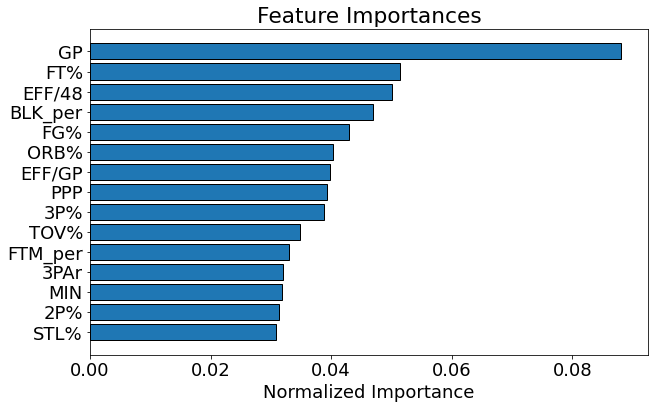

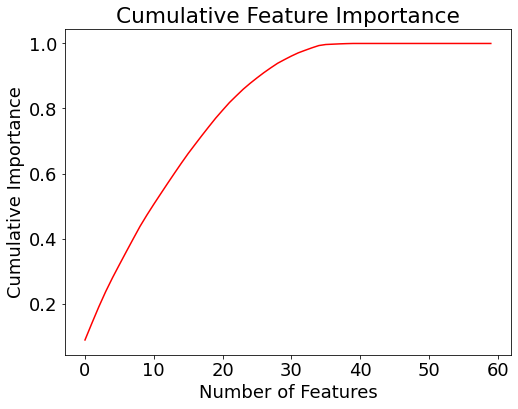

27 features required for 0.90 of cumulative importance


In [113]:
norm_feature_importances = plot_feature_importances(feature_importances)

In [120]:
print('There are %d features with 0.0 importance' % len(zero_features))
train_f1 = train.drop(columns = zero_features)
test_f1 = test.drop(columns = zero_features)

print('Train shape after drop: ', train_f1.shape)
print('Test shape after drop: ', test_f1.shape)

There are 20 features with 0.0 importance
Train shape after drop:  (8000, 40)
Test shape after drop:  (3799, 40)


In [121]:
# Save dataset
train_f1.to_csv("../data/processed/train_f1.csv", index = False)
test_f1.to_csv("../data/processed/test_f1.csv", index = False)

##### **[4.7]** train_drop1

In [122]:
## train_drop1
train = pd.read_csv("../data/processed/train_f1.csv")
test = pd.read_csv("../data/processed/test_f1.csv")
train.shape, test.shape

submission, feature_importances, zero_features, metrics = model(train, test)
metrics

((8000, 40), (3799, 40))

Training Data Shape:  (8000, 40)
Testing Data Shape:  (3799, 40)


,fold,train,valid
0,0,0.856421,0.703297
1,1,0.840150,0.701431
2,2,0.838335,0.716606
3,3,0.842112,0.693706
4,4,0.867180,0.684029
5,overall,0.848840,0.698196


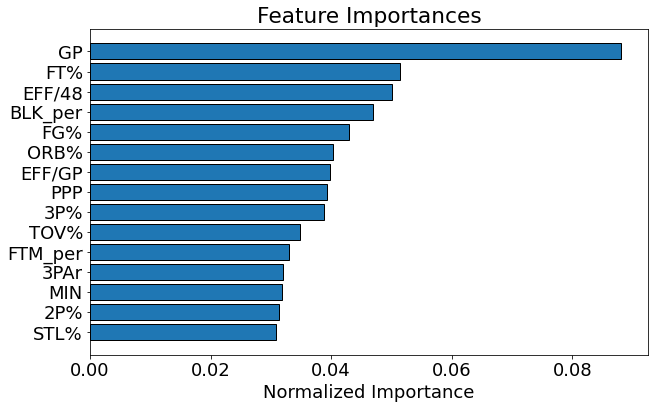

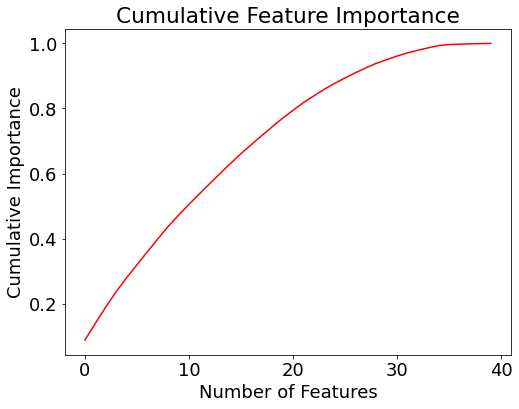

27 features required for 0.90 of cumulative importance


In [123]:
norm_feature_importances = plot_feature_importances(feature_importances)

In [127]:
print('There are %d features with 0.0 importance' % len(zero_features))

There are 0 features with 0.0 importance


Now all features in the dataset has importance > 0. We will keep and use these feature for modeling. 
In this dataset we:
* removed no imformation features
* droped features with missing value greater than 80%
* drop all collinear features with correlation coefficient grater than 0.9


## 5. Visualization

Visualise our new features.

##### **[5.1]** Compare dataset

In [160]:
train = pd.read_csv("../data/processed/train_f1.csv")
train['TARGET_5Yrs'] = y_train_raw

original_features = X_train_raw
f_list = feature_importances['feature'].tolist()

created_features = []

# Iterate through the top 100 features
for feature in feature_importances['feature'][:30]:
    if feature not in original_features:
        created_features.append(feature)

        
print('%d of the were created' % len(created_features))
print("New Features were created:")
[x for x in f_list if x not in list(original_features)]
print()

print("Original Features not in our final dataset:")
[x for x in original_features if x not in list(f_list)]        

20 of the were created
New Features were created:


['EFF/48',
 'BLK_per',
 'ORB%',
 'EFF/GP',
 'PPP',
 'TOV%',
 'FTM_per',
 '3PAr',
 '2P%',
 'STL%',
 'TOV_per',
 'STL/TOV',
 'FTr',
 'DRB%',
 'ASTR',
 'AST/TOV',
 'FTMr',
 'USGr',
 'APM',
 'FT_miss',
 '2P%_sq',
 '2P%_log',
 '3PAr_sq',
 'BLK_per_sq',
 '3P%_anom',
 '3P Made_anom']


Original Features not in our final dataset:


['FGM', 'FGA', '3PA', 'FTA', 'REB']

It makes sense that 'FGM', 'FGA', '3PA', 'FTA', 'REB' are not in our final dataset. 
'FGM', 'FGA', is highly correlated with FG%.
'3PA' is highly correalted with '3P Made' and '3P%'. 
'FTA' is highly correlated with 'FTM' and 'FT%'. 
'REB' is highly correlated with 'OREB' and 'DREB'.

In [161]:
# Create a dataset for visualization
df = train[created_features]
df['TARGET_5Yrs'] = y_train_raw

##### **[5.3]** Kdeplot

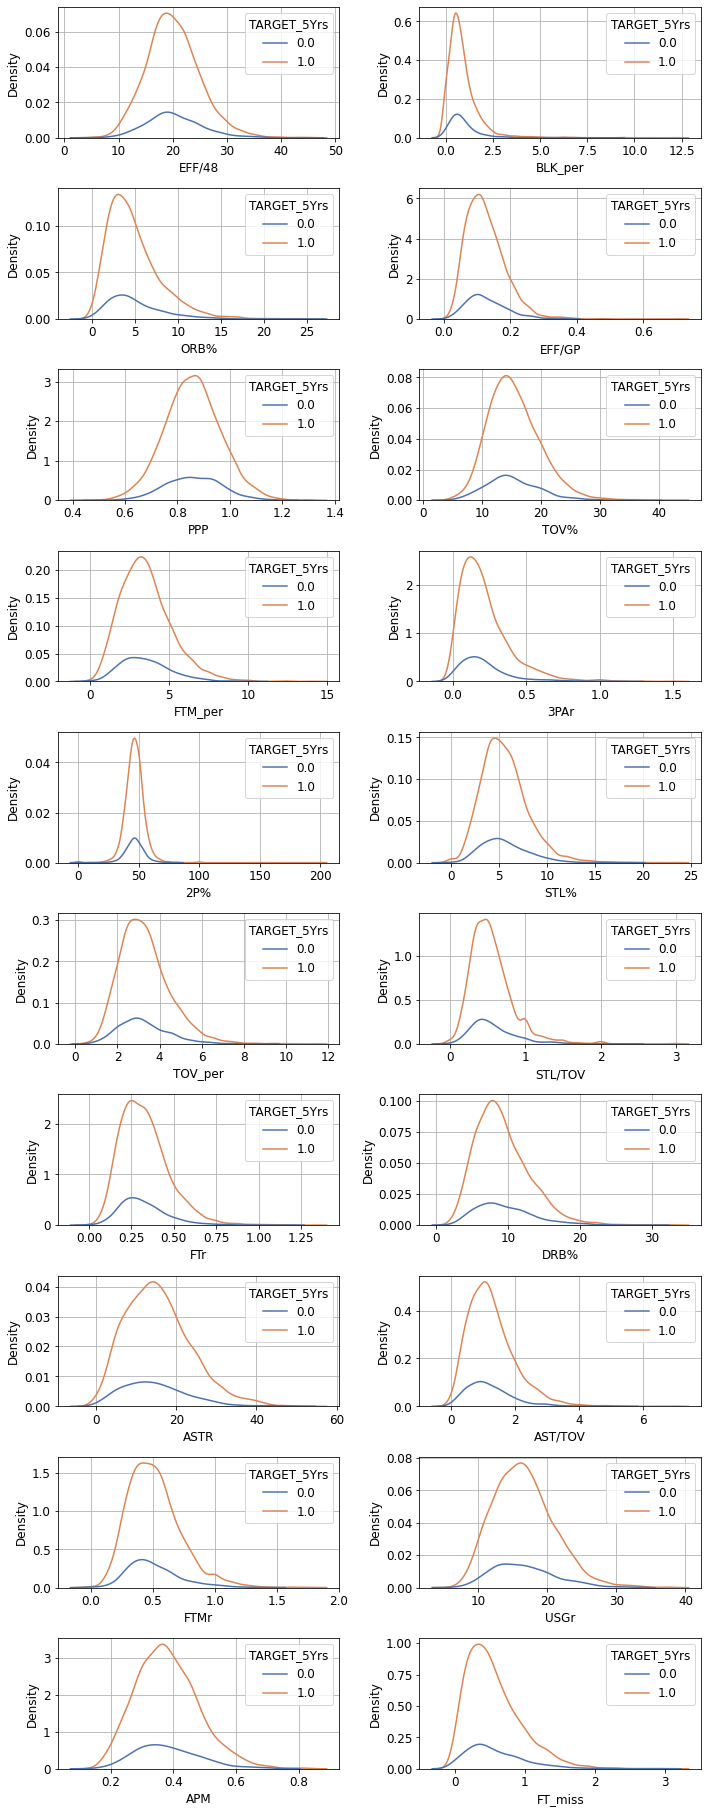

In [196]:
plt.figure(figsize = (10,50))
nrow = 20
ncol = 2
i = 1 
for variable in df.drop(columns = ['TARGET_5Yrs']):
    plt.grid()
    plt.subplot(nrow, ncol, i)
    sns.kdeplot(data = df, x = variable, hue = "TARGET_5Yrs",
                palette="deep")
    i += 1
plt.tight_layout()
plt.show();

##### **[5.3]** scatterplot

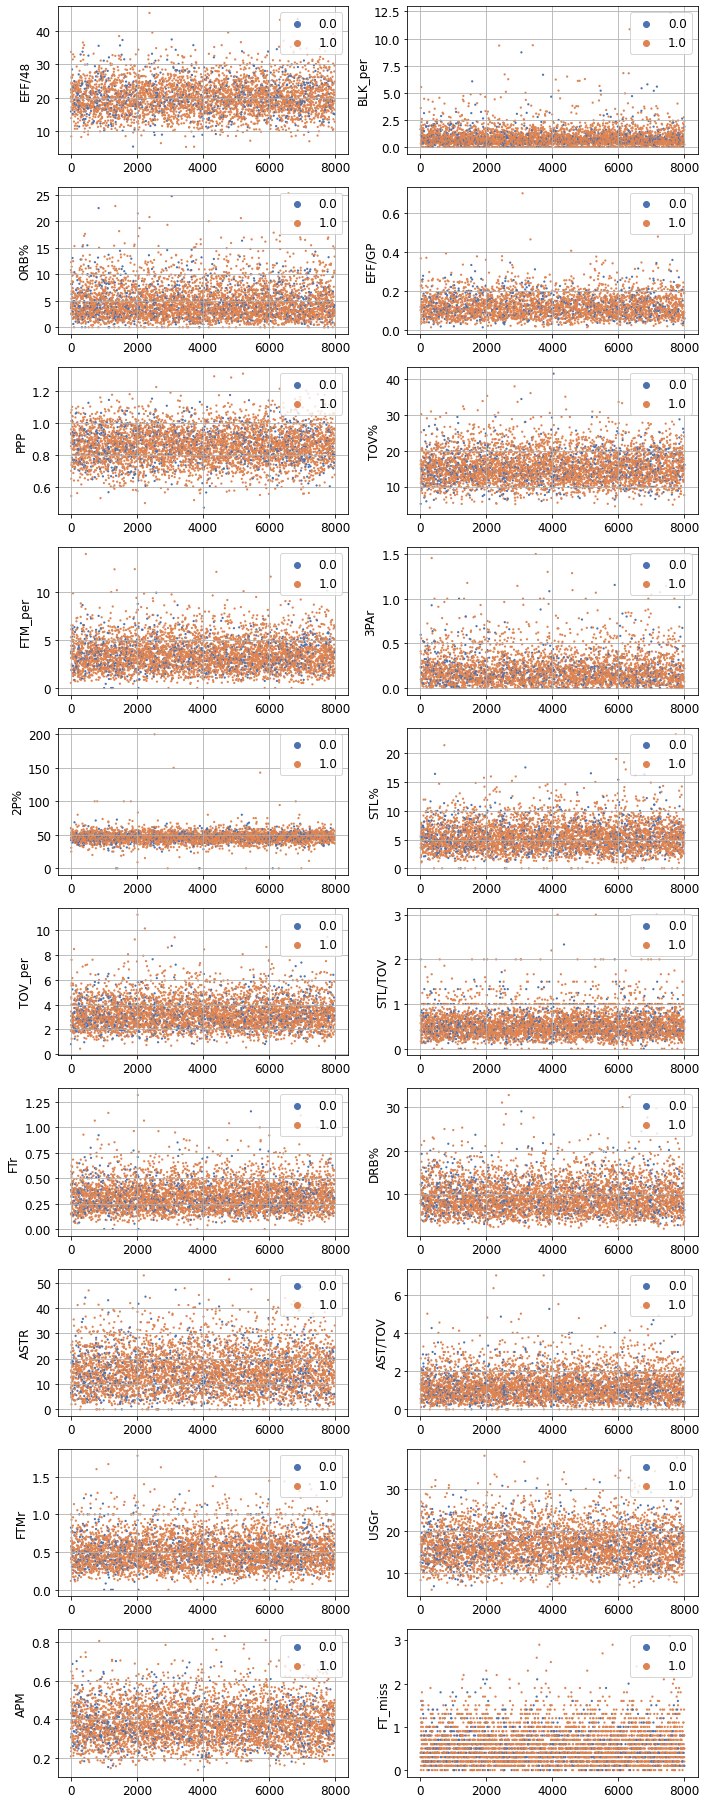

In [197]:
plt.figure(figsize = (10,50))
nrow = 20
ncol = 2
i = 1 
for variable in df.drop(columns = ['TARGET_5Yrs']):
    plt.grid()
    plt.subplot(nrow, ncol, i)
    sns.scatterplot(x = df.index, y = variable, hue = "TARGET_5Yrs", data = df, 
                    edgecolor = 'none', s = 5, palette="deep")
    i += 1
    plt.legend(loc=1)
plt.tight_layout()
plt.show();

##### **[5.3]** Violinplot

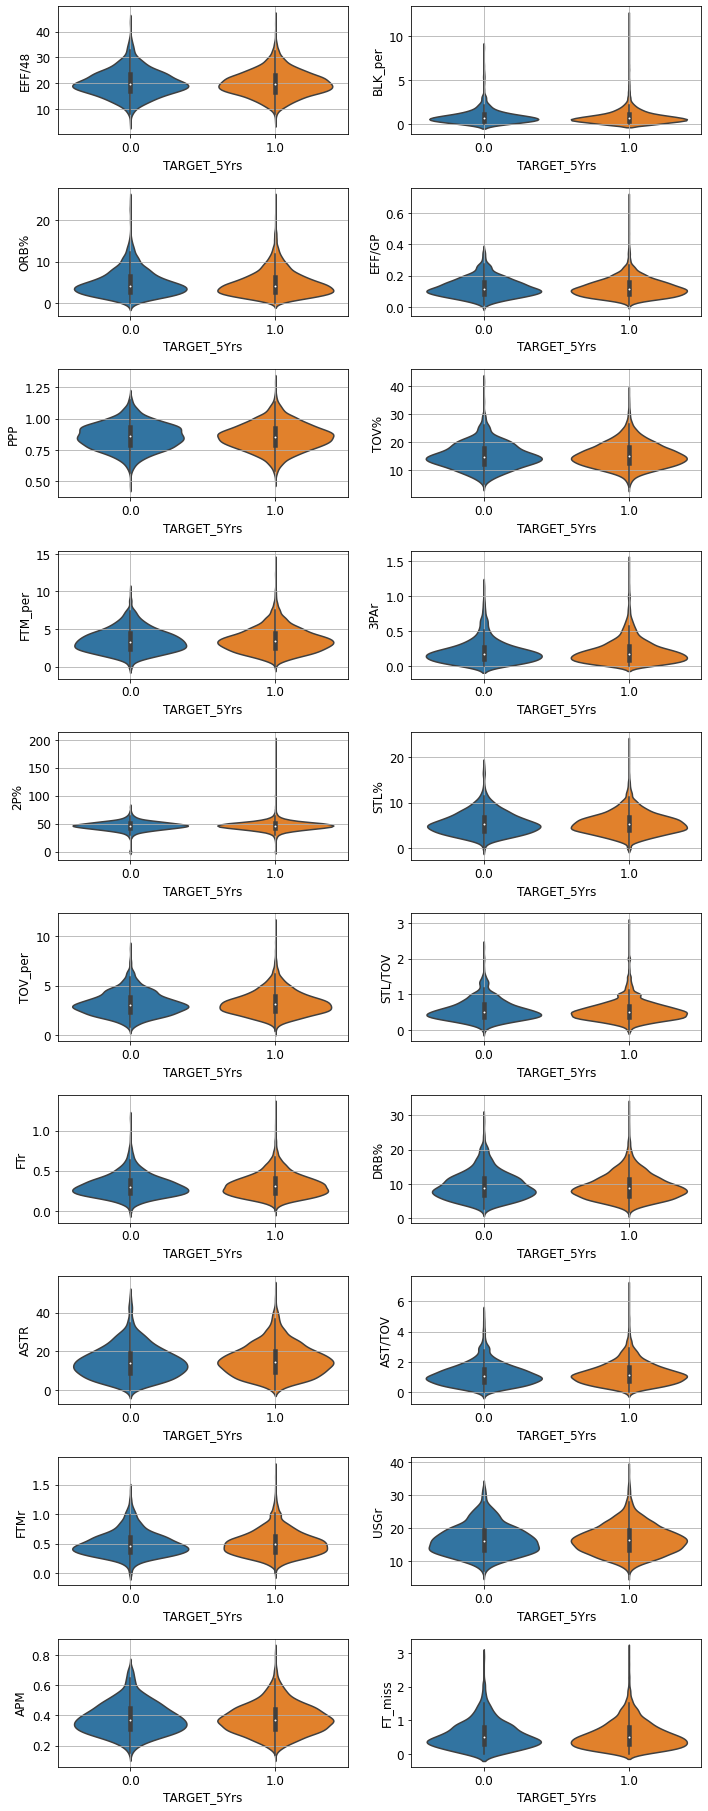

In [204]:
plt.figure(figsize = (10,50))
nrow = 20
ncol = 2
i = 1 
for variable in df.drop(columns = ['TARGET_5Yrs']):
    plt.grid()
    plt.subplot(nrow, ncol, i)
    sns.violinplot(x = "TARGET_5Yrs", y = variable, data = df)
    i += 1
plt.tight_layout()
plt.show();

## 6. K mean start

##### **[6.1]** Prepare dataset

In [207]:
# Load train set
train = pd.read_csv("../data/processed/train_f1.csv")
train_labels = y_train_raw.reset_index(drop=True)

# Load test set
test = pd.read_csv("../data/processed/test_f1.csv")

# Check shape of train and test
train.shape, test.shape

((8000, 40), (3799, 40))

In [208]:
# fill all np.nan with mode of each column
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X_train = imputer.fit_transform(train)
X_test = imputer.transform(test)

In [209]:
# Combine test & train to form all_X
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
all_X = X_train.append(X_test)
all_X.shape

(11799, 40)

In [210]:
# Standardise all_X to achieve better result on K-Mean clustering
scaled_data = StandardScaler().fit_transform(all_X)

In [211]:
# Find best number of clusters
sil = []
kmax = 12
my_range=range(2,kmax+1)
for i in my_range:
    kmeans = cluster.KMeans(n_clusters = i).fit(scaled_data)
    labels = kmeans.labels_
    sil.append(silhouette_score(scaled_data, labels, metric =  
    'correlation'))

Text(0.5, 0, 'k')

Text(0, 0.5, 'Silhouette Score')

Text(0.5, 1.0, 'Silhouette Score by K')

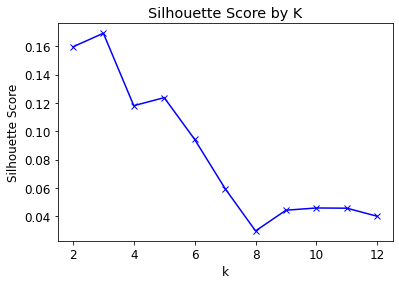

In [212]:
# Plot it, finding 2 is the ideal overall (all columns) cluster
plt.plot(my_range, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score by K')
plt.show()

We can see the clustering is the best at 3. So we'll use 3 as the number of cluster in Gaussian Mixture.
Below cell is for K-mean clustering, not shown here. This version is for Gaussian Mixture shown later.

In [78]:
# all_X_cluster['LABELS'] = cluster.KMeans(n_clusters=3).fit(scaled_data).labels_

# #Analyze labels
# clusters = pd.DataFrame(columns=(all_X_cluster.iloc[:, :]).columns)
# for i in range(0, 3):
#     a = all_X_cluster[all_X_cluster['LABELS'] == i].mean()
#     clusters = clusters.append(a, ignore_index=True)

# #Show information we want
# clusters

Use GaussianMixture to find optimal cluster number

In [213]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3, random_state=9999)
gmm.fit(all_X)
gmm.predict(all_X)

GaussianMixture(n_components=3, random_state=9999)

array([2, 2, 2, ..., 2, 2, 2])

In [214]:
Label = pd.DataFrame(gmm.predict(all_X))
all_X['Label'] = Label

##### **[6.2]** Seperate dataset

In [215]:
X_train = all_X.iloc[:len(y_train), :]
X_test = all_X.iloc[len(y_train):, :]
X_train.shape, y_train.shape, X_test.shape

((8000, 41), (8000,), (3799, 41))

##### **[6.3]** Standardise

In [216]:
# Instantiate the StandardScaler
scaler = StandardScaler()

# Fit and apply the scaling on data and test
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [217]:
# Save the scaler into the folder models and call the file scaler.joblib
dump(scaler, '../models/scaler.joblib')

['../models/scaler.joblib']

##### **[6.4]** Split dataset & Save

In [218]:
# Split the data (80%) randomly with random_state=8 into 2 different sets: training (80%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.2,
                                                  random_state=0,
                                                  stratify=y_train)

In [219]:
np.save('../data/processed/X_train', X_train)
np.save('../data/processed/y_train', y_train)

np.save('../data/processed/X_val', X_val)
np.save('../data/processed/y_val', y_val)

np.save('../data/processed/X_test', X_test)

In [224]:
from sklearn.decomposition import PCA
# from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(missing_values=np.nan, strategy='mean')


# Make a pipeline with imputation and pca
pipeline = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'median')),
             ('pca', PCA())])

# Fit and transform on the training data
train_pca = pipeline.fit_transform(train)

# transform the testing data
test_pca = pipeline.transform(test)

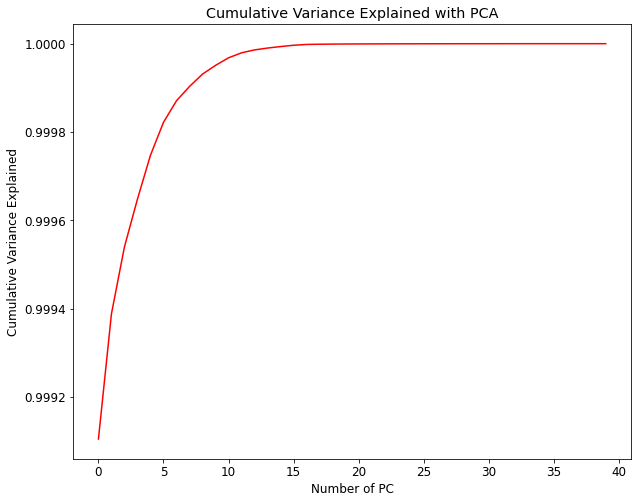

In [225]:
# Extract the pca object
pca = pipeline.named_steps['pca']

# Plot the cumulative variance explained

plt.figure(figsize = (10, 8))
plt.plot(list(range(train.shape[1])), np.cumsum(pca.explained_variance_ratio_), 'r-')
plt.xlabel('Number of PC'); plt.ylabel('Cumulative Variance Explained');
plt.title('Cumulative Variance Explained with PCA');

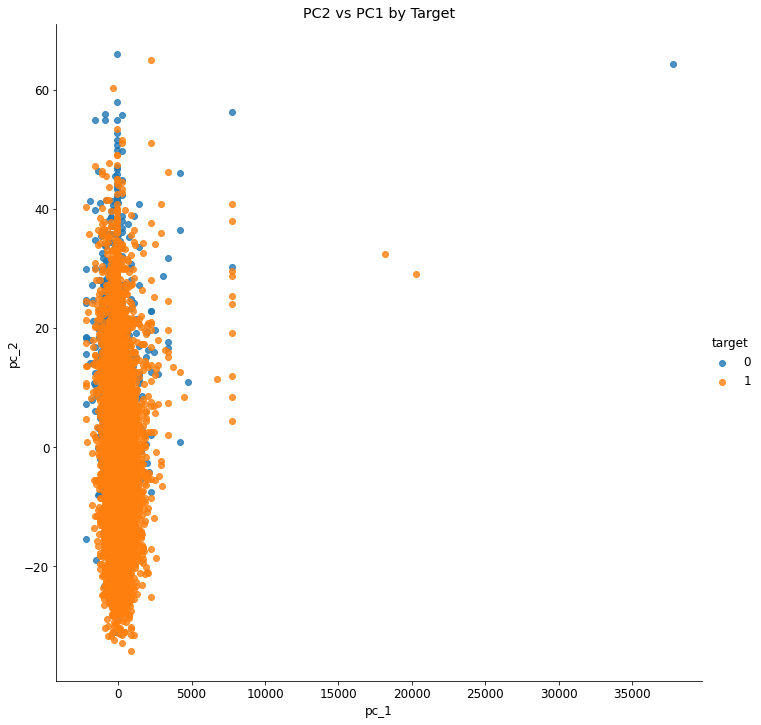

In [226]:
# Dataframe of pca results
pca_df = pd.DataFrame({'pc_1': train_pca[:, 0], 'pc_2': train_pca[:, 1], 'target': train_labels})

# Plot pc2 vs pc1 colored by target
sns.lmplot('pc_1', 'pc_2', data = pca_df, hue = 'target', fit_reg=False, size = 10)
plt.title('PC2 vs PC1 by Target');

In [227]:
print('2 principal components account for {:.4f}% of the variance.'.format(100 * np.sum(pca.explained_variance_ratio_[:2])))

2 principal components account for 99.9389% of the variance.
